 [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ZRUudjsf0ofOMVjhzfF239Df3BaO2jqp#scrollTo=n0aJxtzZMCSI&uniqifier=4)

# `STARSKØPE-2`



**Building a Cyberoptic Artificial Telescope**

> PART II: Spectrograph image classification with Keras CNN



# Import

Once again let's import the requisite libraries and our dataset.

In [ ]:

import numpy as np
import pandas as pd
import matplotlib as mpl
%matplotlib inline
from matplotlib.colors import LogNorm

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
 

font_dict={'family':'"Titillium Web", monospace','size':16}
mpl.rc('font',**font_dict)


#ignore pink warnings
import warnings
warnings.filterwarnings('ignore')
# Allow for large # columns
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows','')

Import dataset which has already been split into train and test sets, `exoTrain.csv.zip` and `exoTest.csv.zip` (I compressed them from their original csv format since the training set is > 240 MB so we'll to unzip them).

In [10]:
# Use this instead if using Jupyter notebook/local
# import os, glob, sys
# home = os.path.abspath(os.curdir)
# os.listdir(home)
# %cd ../
# %cd data
# %ls


# navigating to dataset on google colabs - step 1 mount drive
from google.colab import drive
drive.mount('/gdrive',force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [11]:
%cd /gdrive

/gdrive


In [12]:
# google colabs step 2 - change directory to `data`
%cd 'My Drive/Colab Notebooks/starskope/data'/
%ls

/gdrive/My Drive/Colab Notebooks/starskope/data
 cumulative.csv                         exoTrain.csv
 data/                                  exoTrain.csv.zip
 emissionspec_2020.01.30_19.43.11.csv  'Icon'$'\r'
 exoTableDraw.R                         __MACOSX/
 exoTest.csv                            oec.csv
 exoTest.csv.zip                        transitspec_2020.01.30_19.38.06.csv


In [ ]:
# uncomment below if you need to unzip the data files
# !unzip -q 'exoTrain.csv.zip'
# !unzip -q 'exoTest.csv.zip'
# %ls

In [ ]:
# read in train and test files
train = pd.read_csv('exoTrain.csv')
test = pd.read_csv('exoTest.csv')

In [6]:
# cd backto home / root directory
%cd ../

/gdrive/My Drive/Colab Notebooks/starskope


# Convert data to Spectrographs

In [ ]:
# create datasets for spectrographs
train_planets = train.loc[train['LABEL'] == 2]
train_negatives = train.loc[train['LABEL'] == 1]
test_planets = test.loc[test['LABEL'] == 2]
test_negatives = test.loc[test['LABEL'] == 1]

In [ ]:
# remove label columns before creating images
test_planets = test_planets.copy().drop(columns=['LABEL'], axis=1)
test_negatives = test_negatives.copy().drop(columns=['LABEL'], axis=1)
train_planets = train_planets.copy().drop(columns=['LABEL'], axis=1)
train_negatives = train_negatives.copy().drop(columns=['LABEL'], axis=1)

In [ ]:
# Uncomment if you are running for the first time
# %mkdir specs
# %mkdir specs/train
# %mkdir specs/test

# %mkdir specs/train/planets
# %mkdir specs/train/negatives
# %mkdir specs/test/planets
# %mkdir specs/test/negatives

In [ ]:
# setup paths for storing images in folders created above 
import os
from os import path

train_outpath = "./specs/train"
test_outpath = "./specs/test"

train_planets_outpath = "./specs/train/planets"
train_negatives_outpath = "./specs/train/negatives"
test_planets_outpath = "./specs/test/planets"
test_negatives_outpath = "./specs/test/negatives"

In [ ]:
def specgrams_for_ML(dataframe, outpath, figsize=(9,9),mode=None,cmap=None):
    """Creates 9x9 square spectrograph image of a signal passed as array
    Ideal for machine learning image classification (no axes or colorbar)

    signal: takes an array. ex: signal = np.array(test_data.loc[0]) 
    Fs = default is 2
    NFFT: default is 256
    noverlap: default is None
    mode: 'PSD', 'phase', 'magnitude', 'angle'
    cmap: see matplotlib specgram for options (there's a ton)
    * default is 'binary' which is black and white
    * my favorites are: 'magma', 'inferno' and 'jet'

    create black and white specgram:
    specgram_for_ML(signal)

    # TODO : option to generate fourier-transform specgrams
    fourier transform
    rf = np.fft.rfft(signal)
    rf = np.fft.rfftfreq(n=signal.size,d=1/9)
    rfshift = np.fft.fftshift(rf)
    rfspec, rfqs, t, m = make_specgram(rfshift,Fs=2,cmap='magma',mode='psd',save_for_ML=True)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    if mode is None:
        mode='psd'
    if cmap is None:
        cmap = 'binary'
    
    for i in dataframe.index:
        signal = np.array(dataframe.iloc[i])
        fig, ax = plt.subplots(figsize=figsize,frameon=False)
        fig, freqs, t, m = plt.specgram(signal, Fs=2, NFFT=256, mode=mode,cmap=cmap)
        plt.axis(False)
        plt.savefig(path.join(outpath,'spec_{0}'.format(i)),bbox_inches='tight')

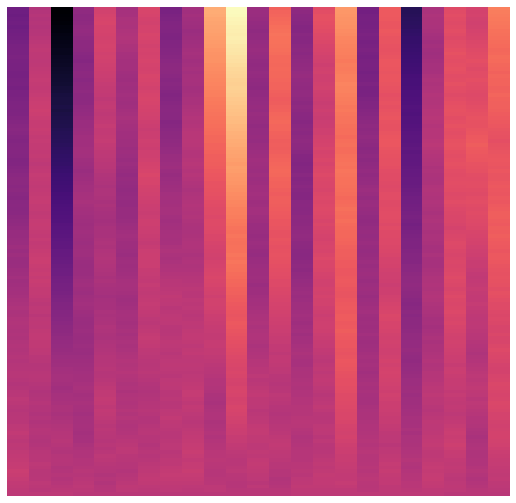

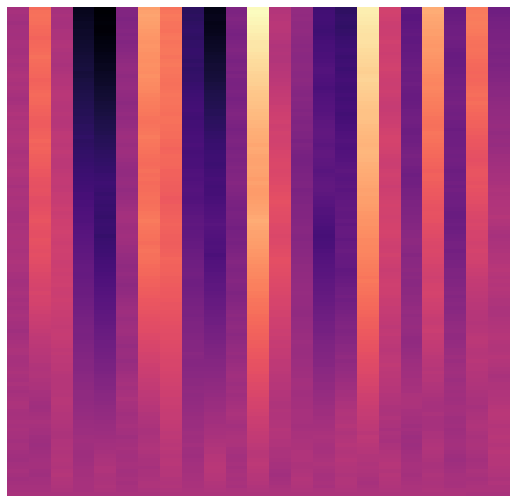

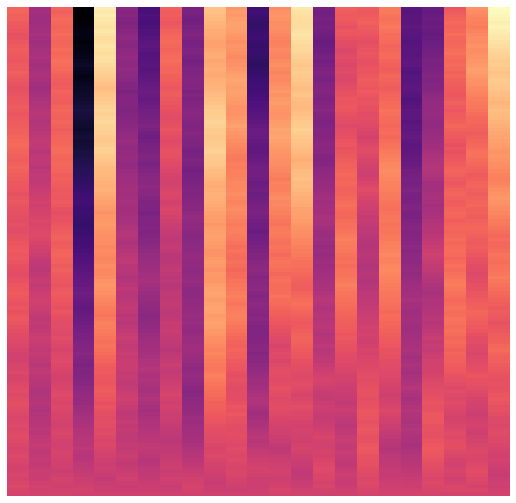

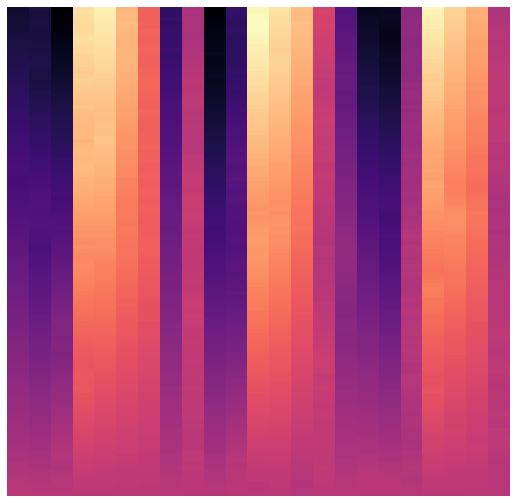

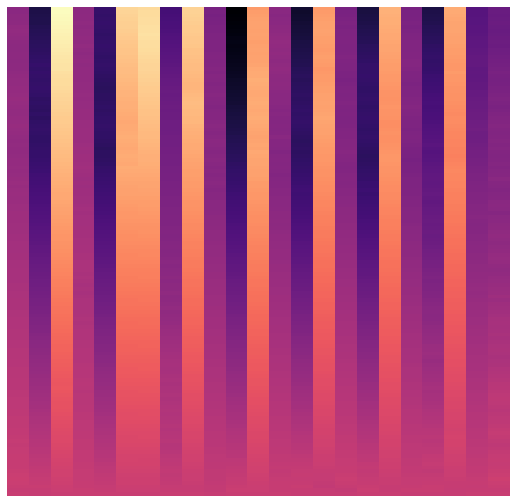

In [30]:
specgrams_for_ML(test_planets, test_planets_outpath,figsize=(9,9),
                 mode='phase',cmap='magma')

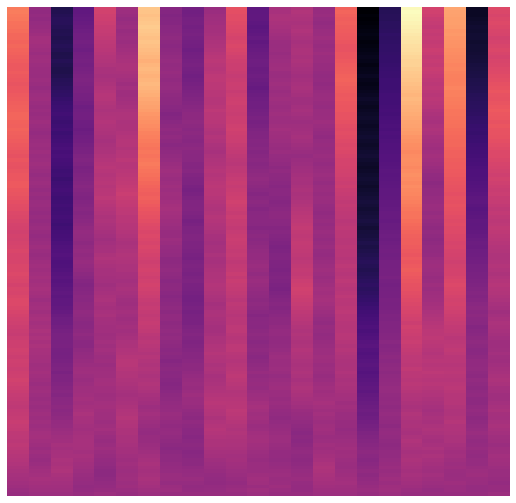

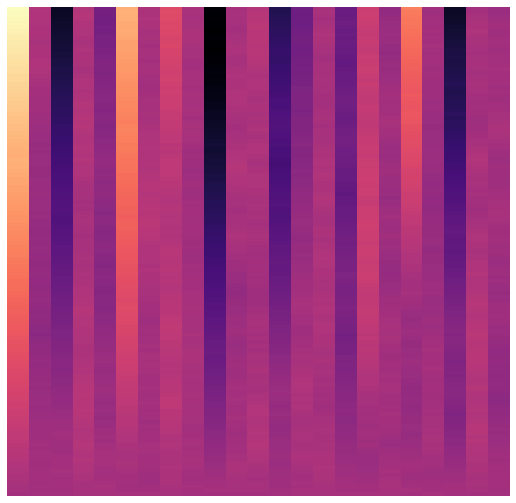

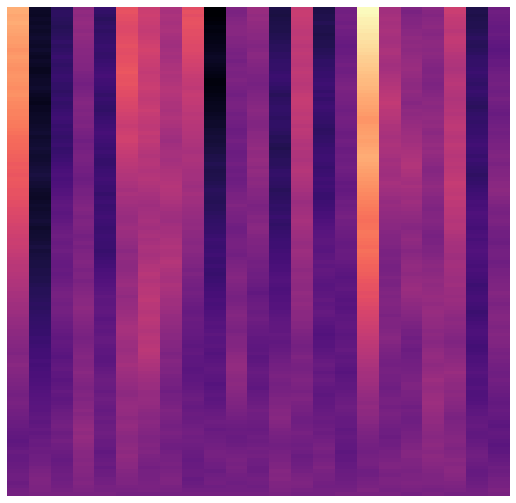

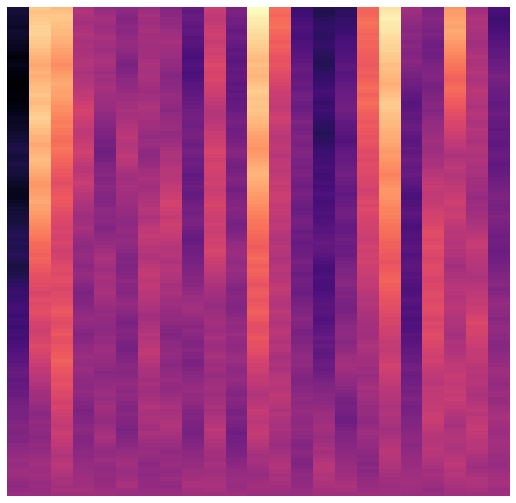

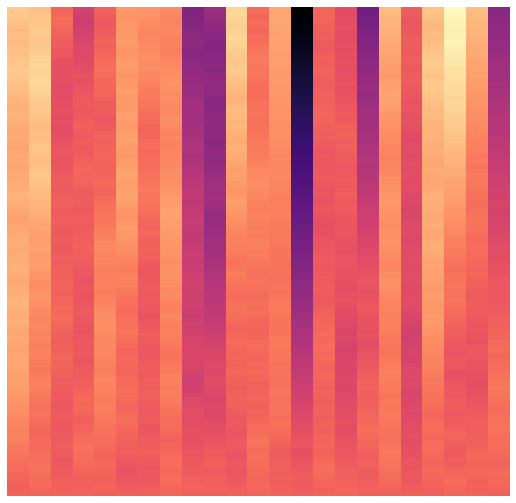

In [35]:
# limiting to 5 to match class weights
counter = 0
for i in test_negatives.index:
    if counter < 5:
        signal = np.array(test_negatives.iloc[i])
        fig, ax = plt.subplots(figsize=(9,9),frameon=False)
        fig, freqs, t, m = plt.specgram(signal, Fs=2, NFFT=256, mode='phase',cmap='magma')
        plt.axis(False)
        plt.savefig(path.join(test_negatives_outpath,'spec_{0}'.format(i)),bbox_inches='tight')
        counter+=1

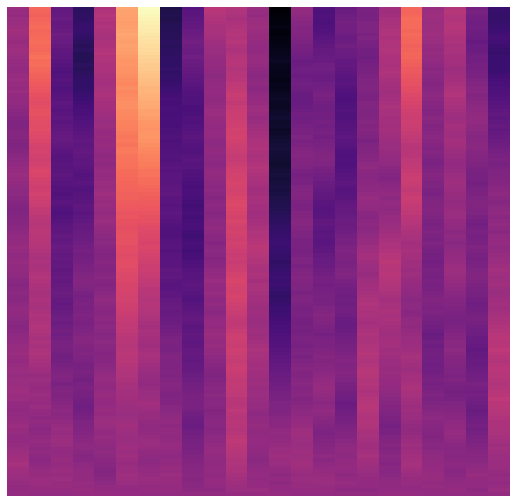

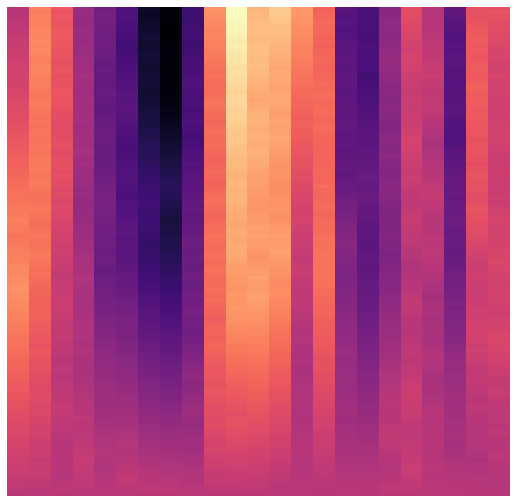

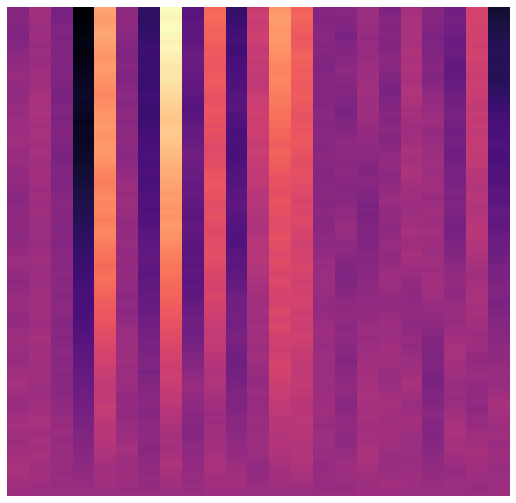

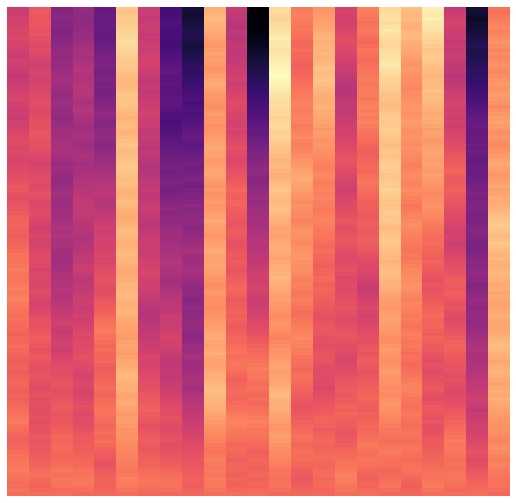

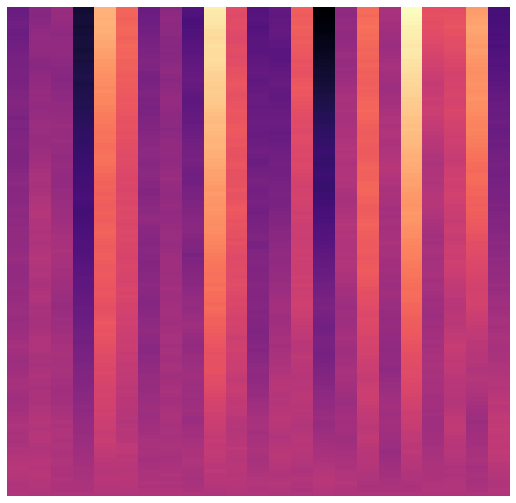

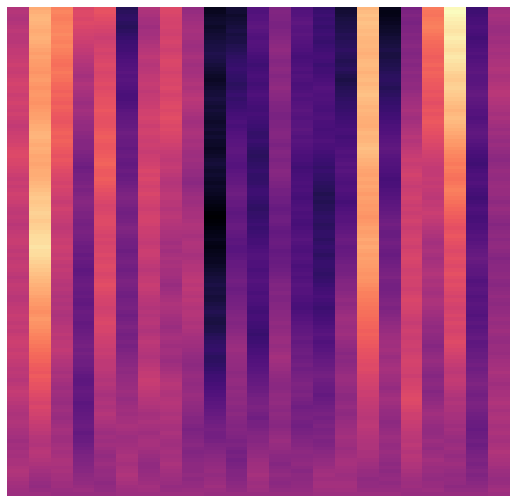

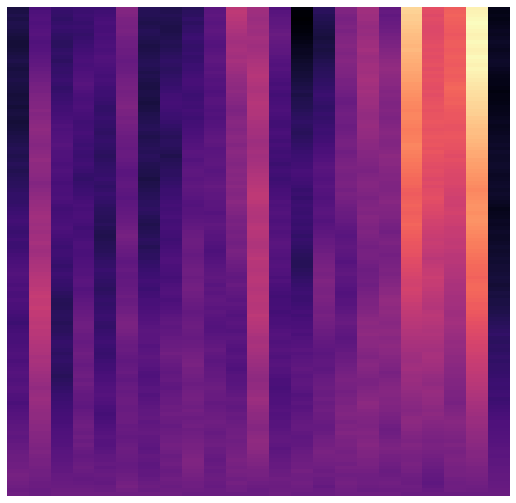

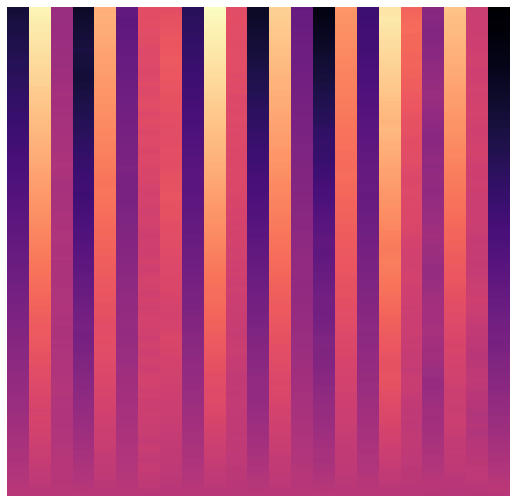

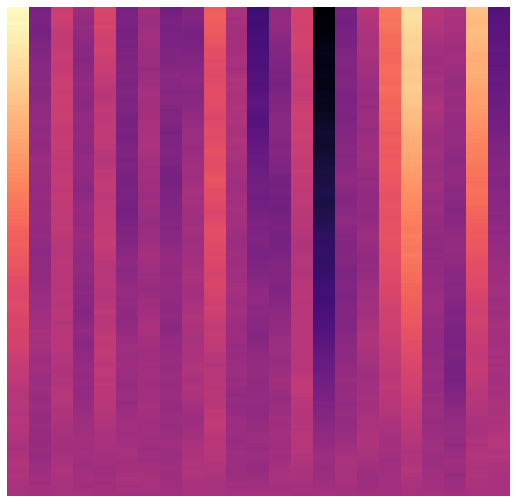

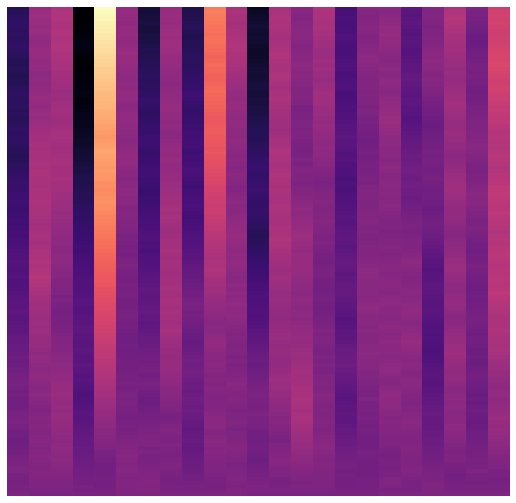

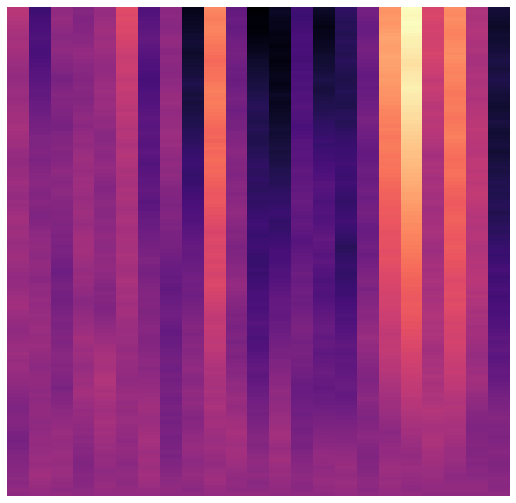

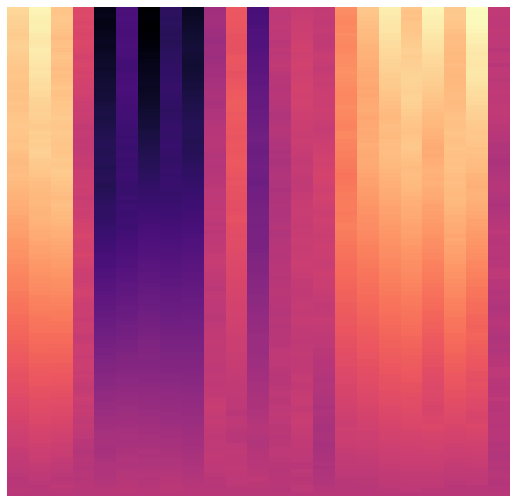

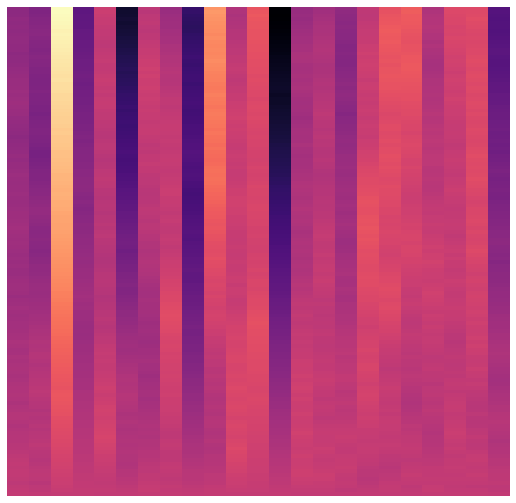

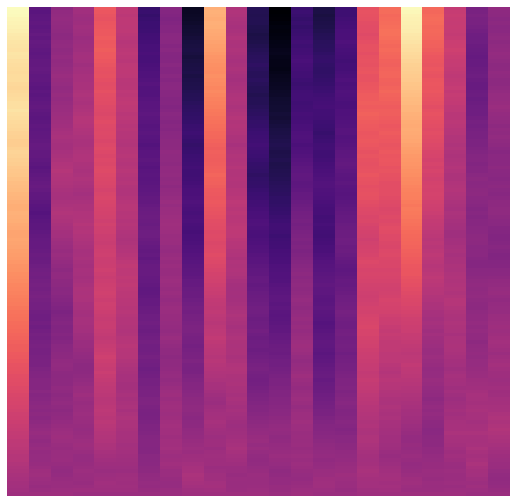

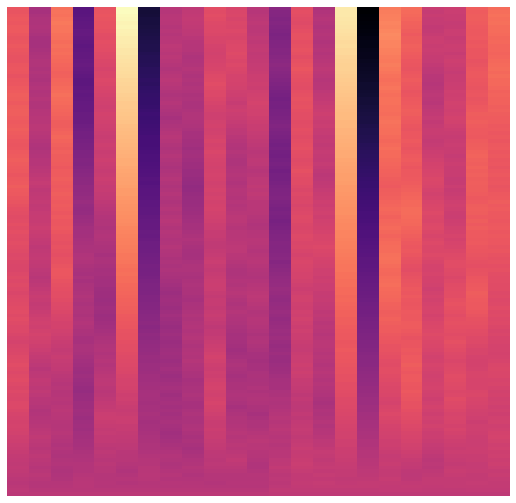

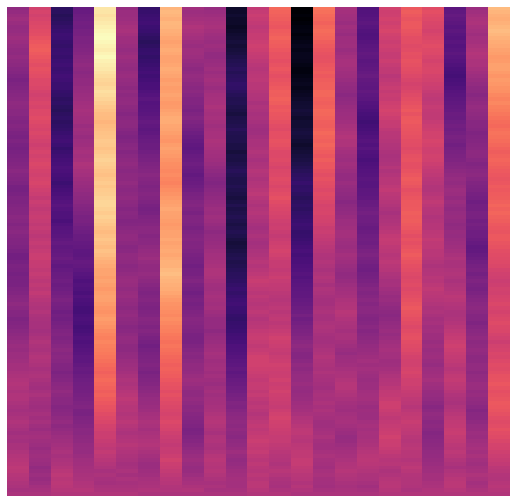

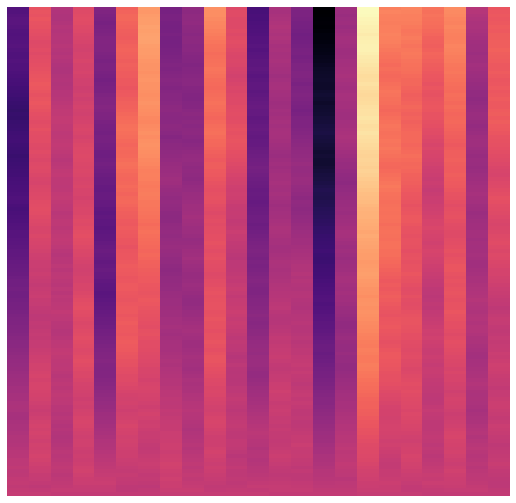

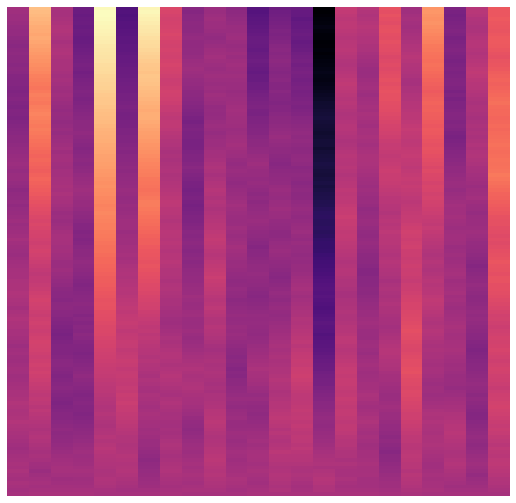

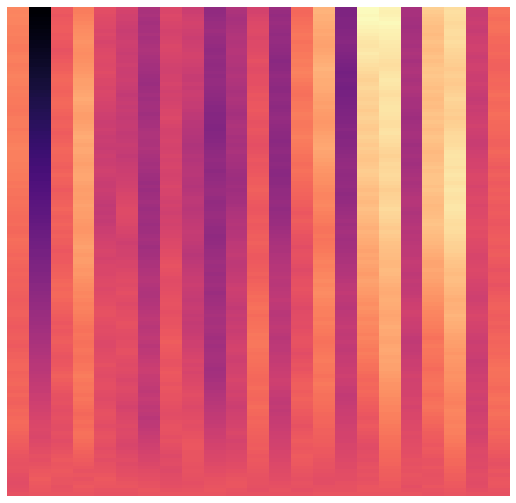

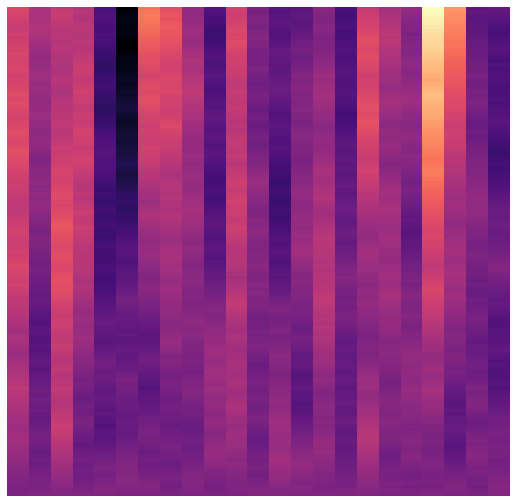

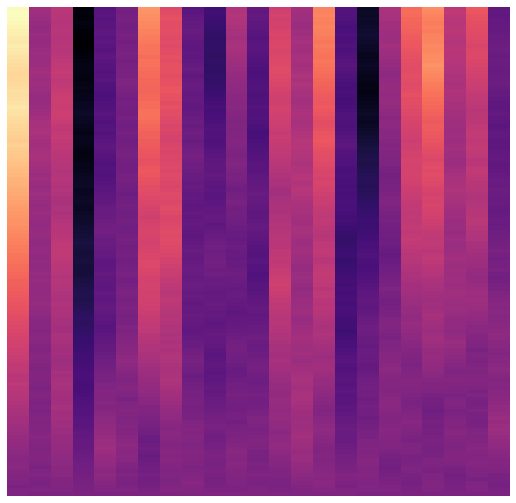

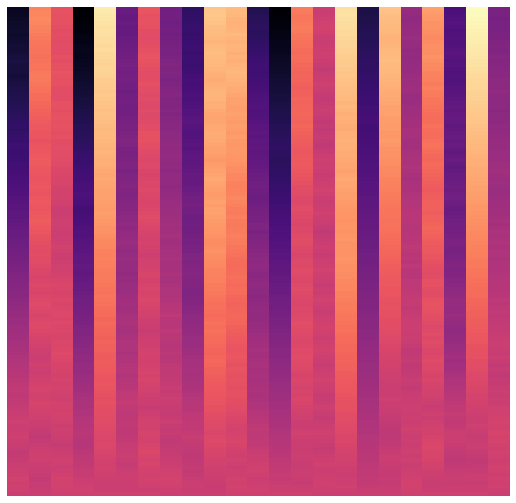

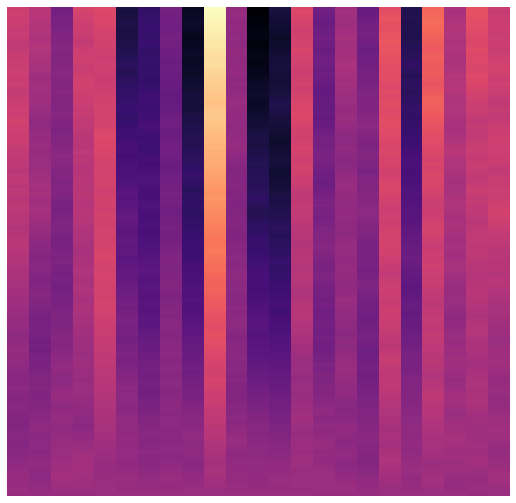

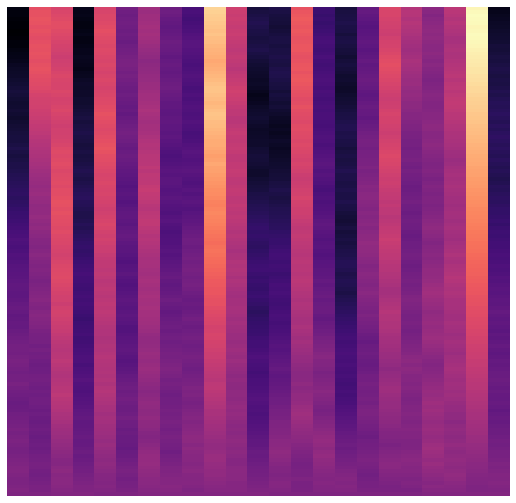

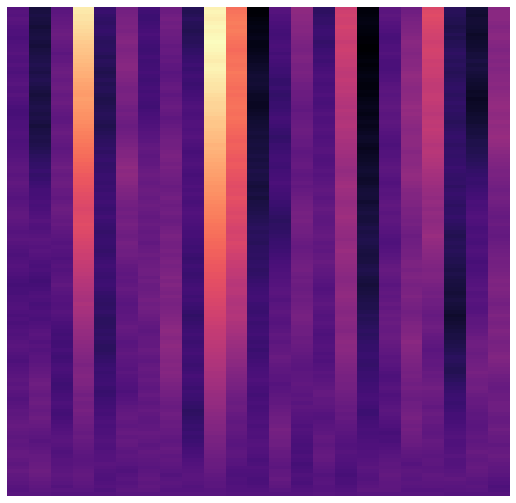

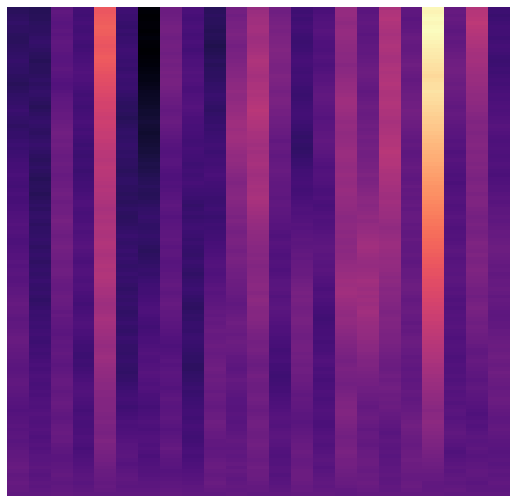

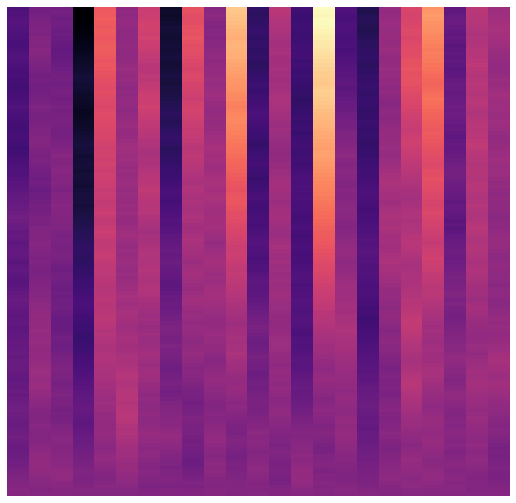

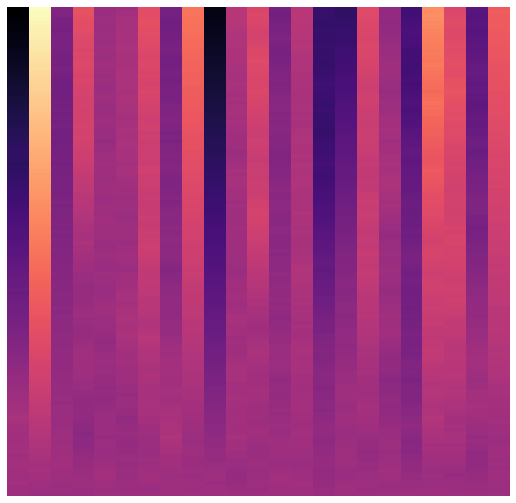

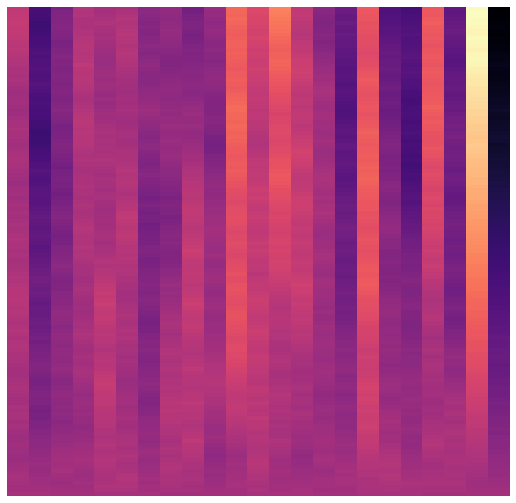

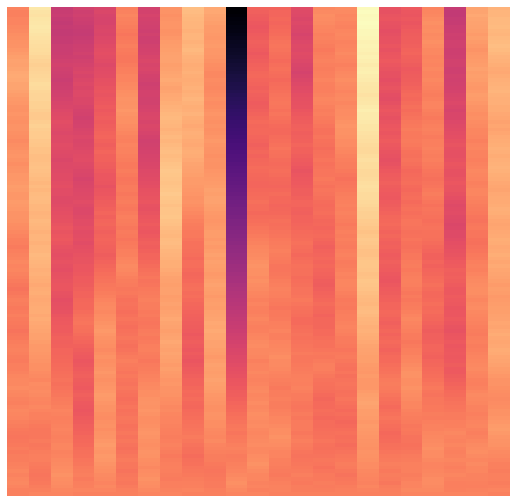

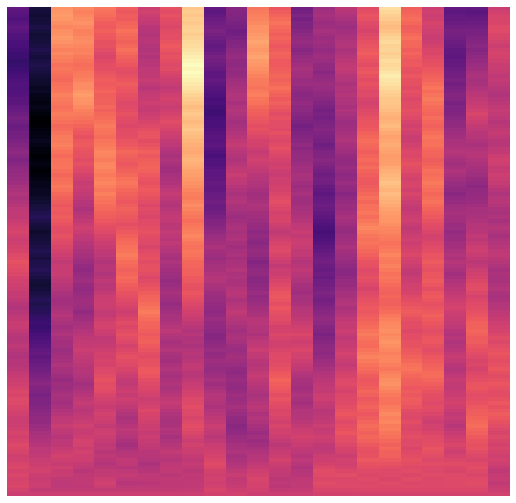

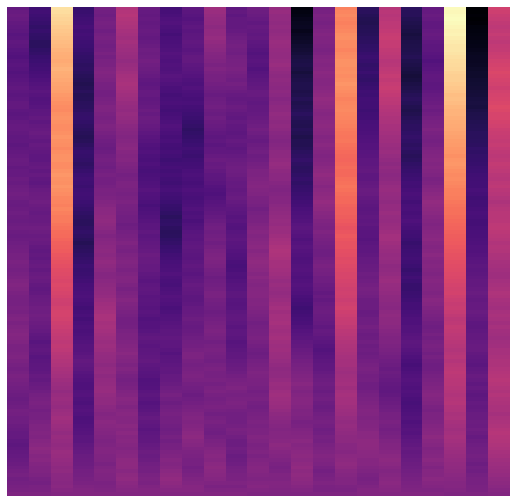

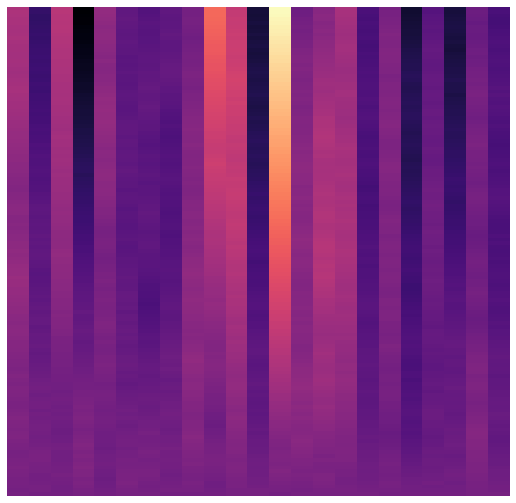

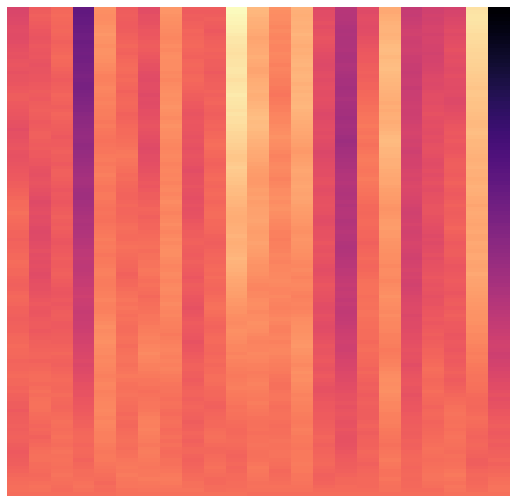

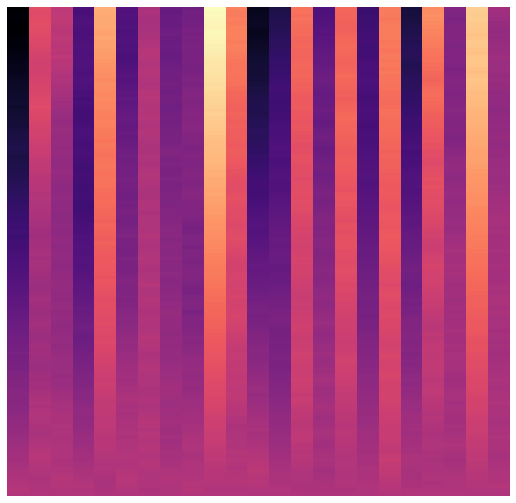

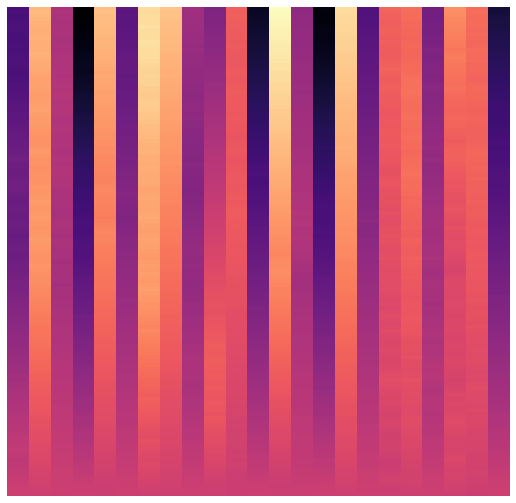

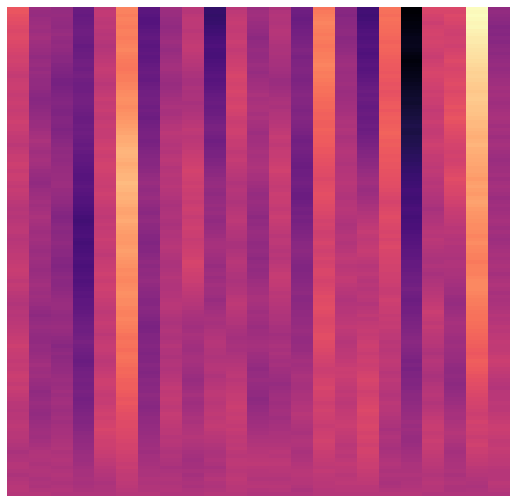

In [36]:
specgrams_for_ML(train_planets, train_planets_outpath,figsize=(9,9),
                 mode='phase',cmap='magma')

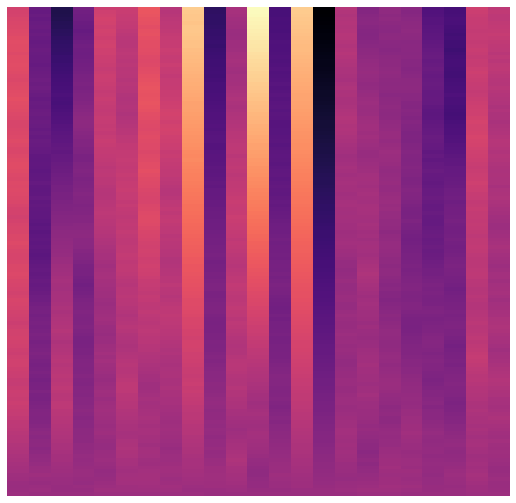

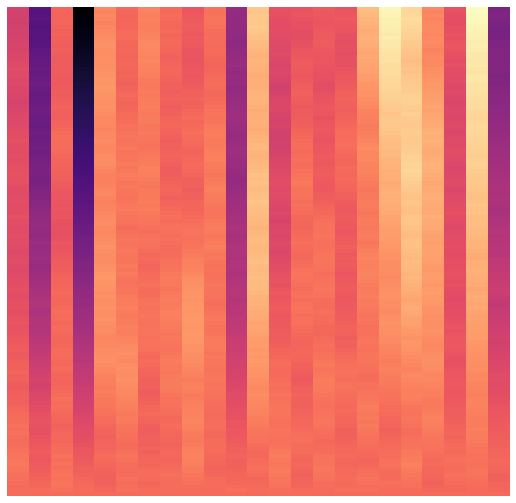

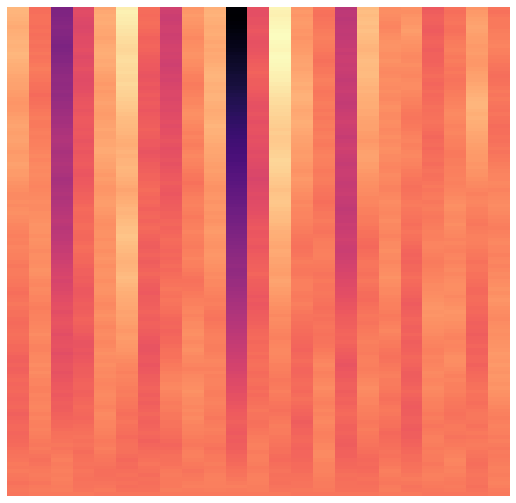

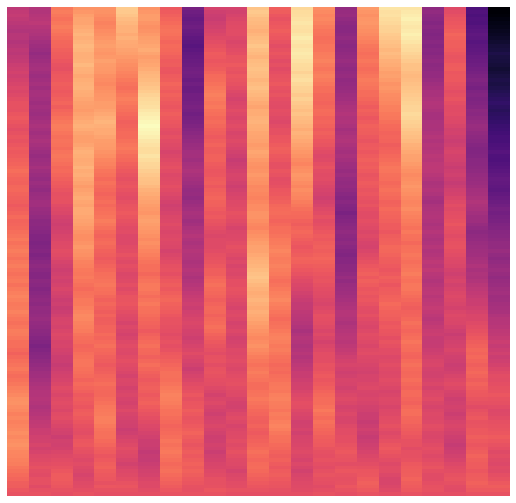

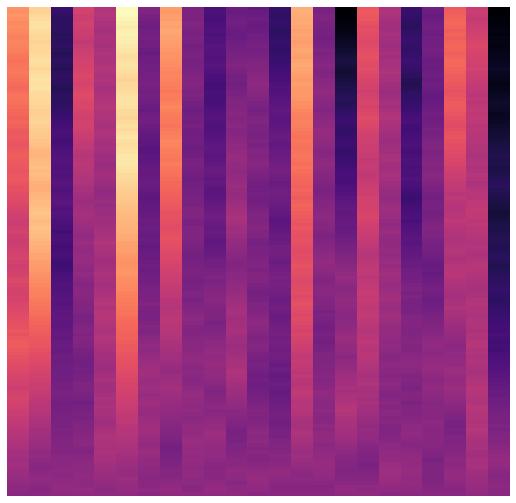

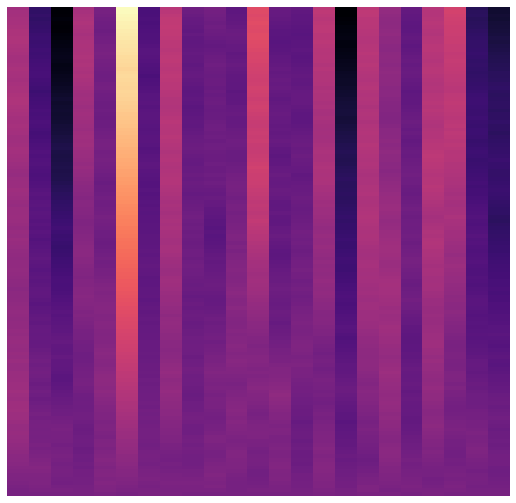

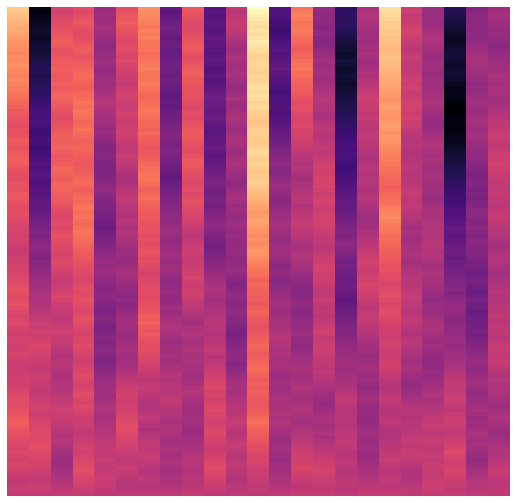

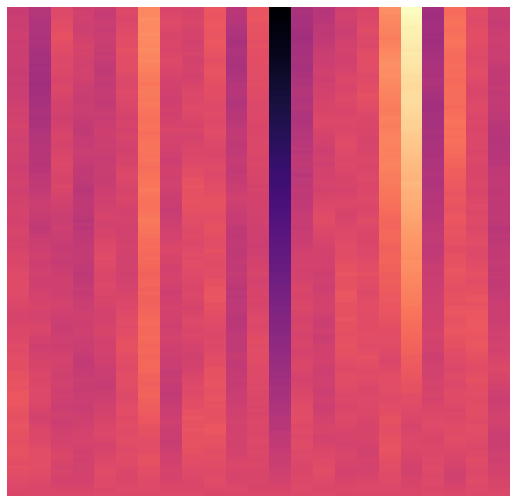

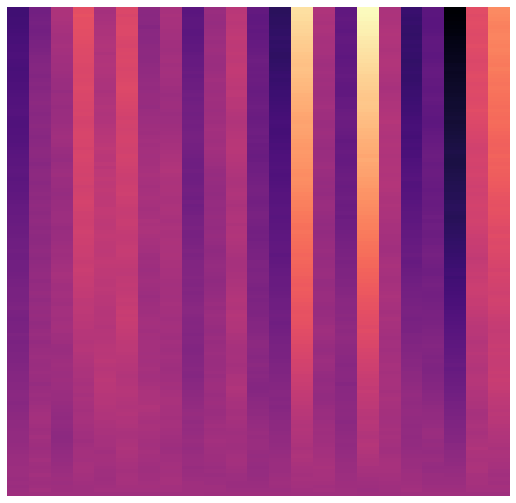

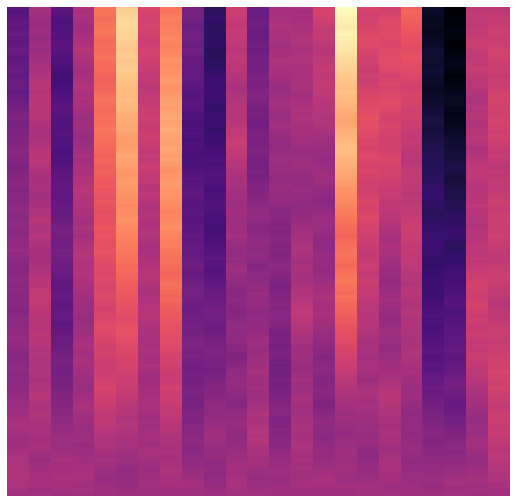

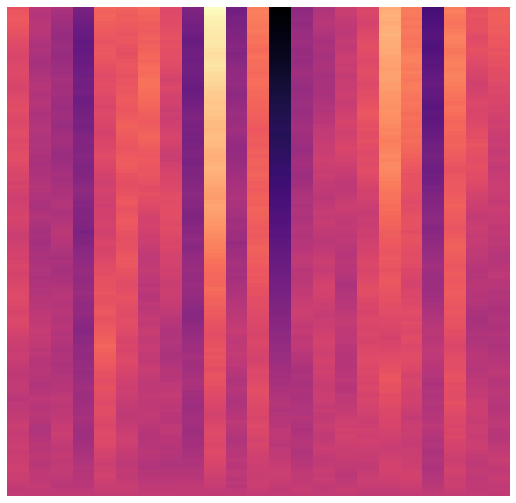

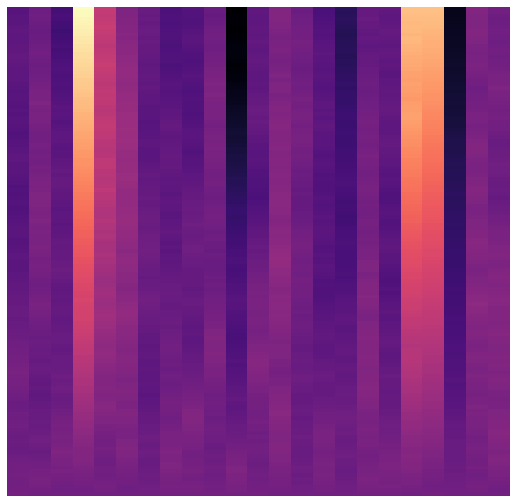

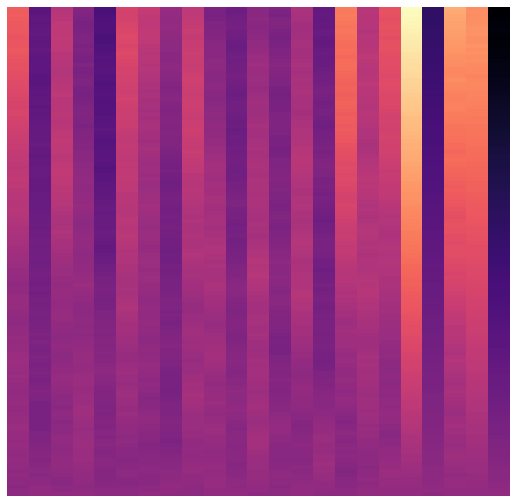

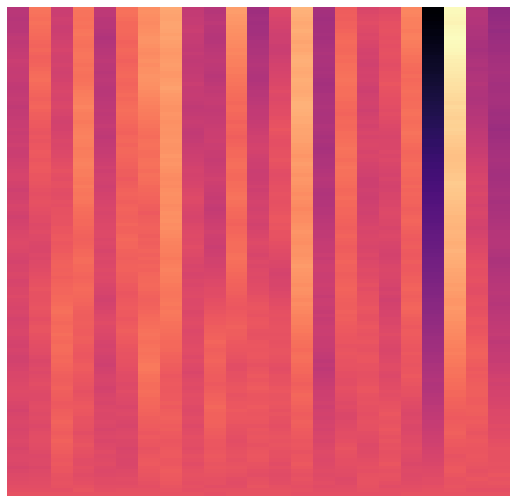

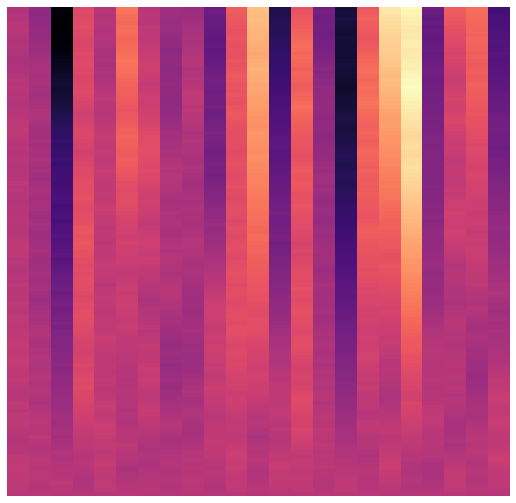

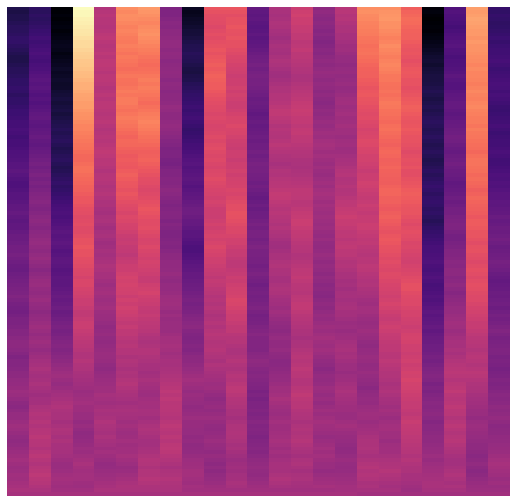

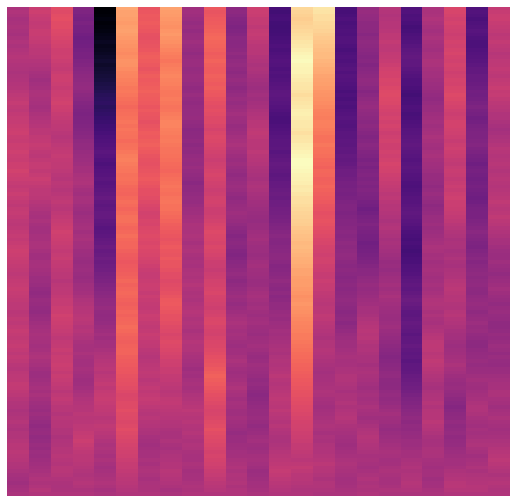

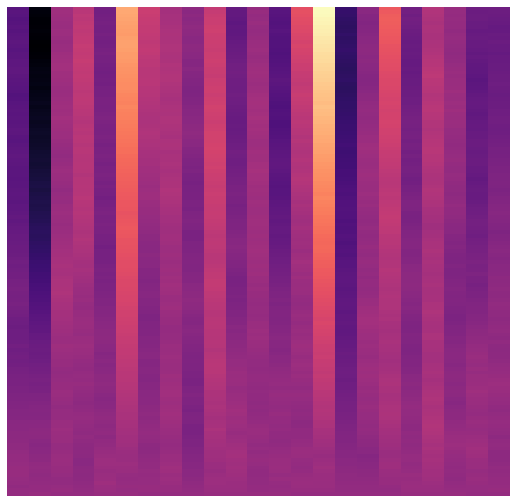

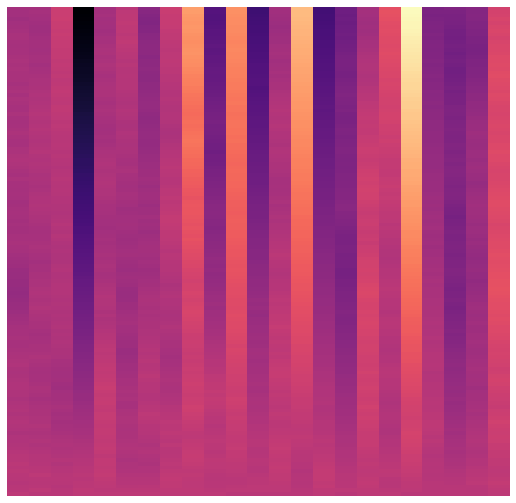

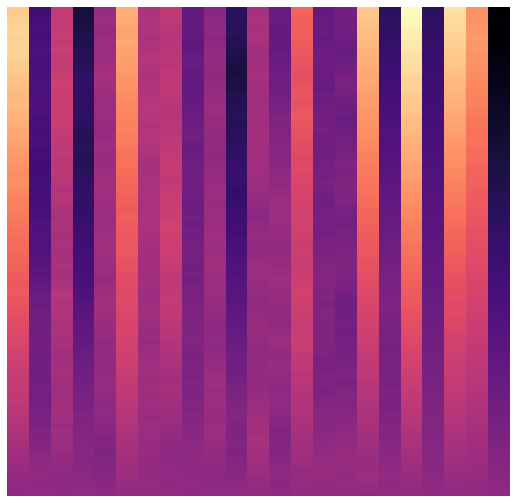

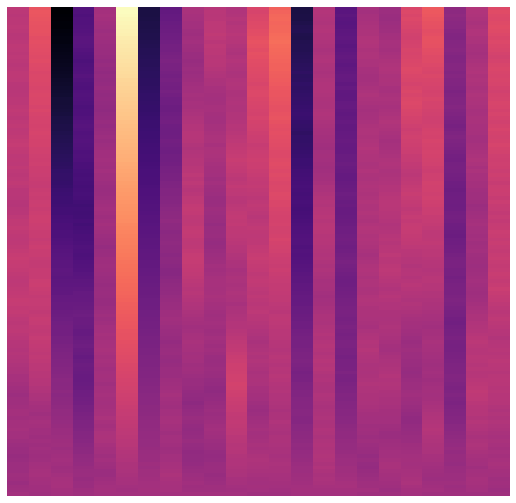

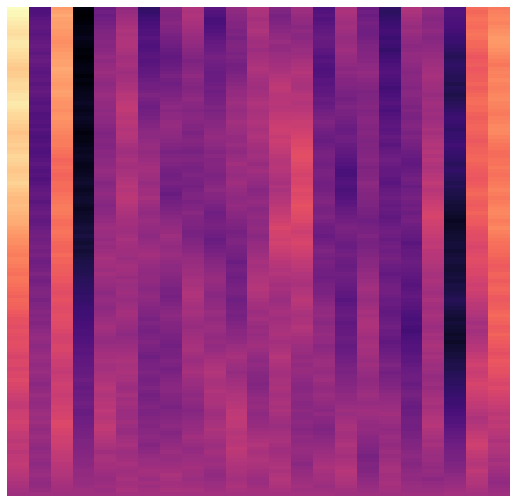

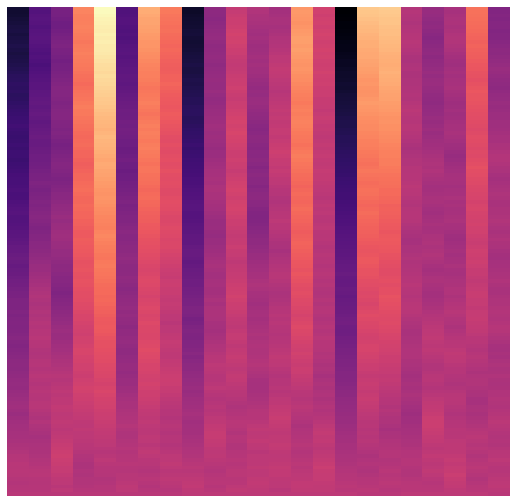

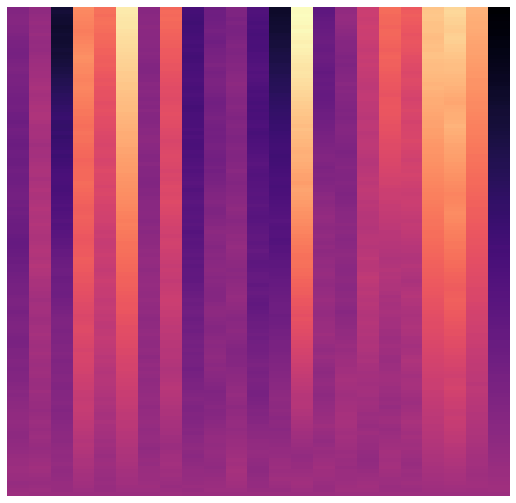

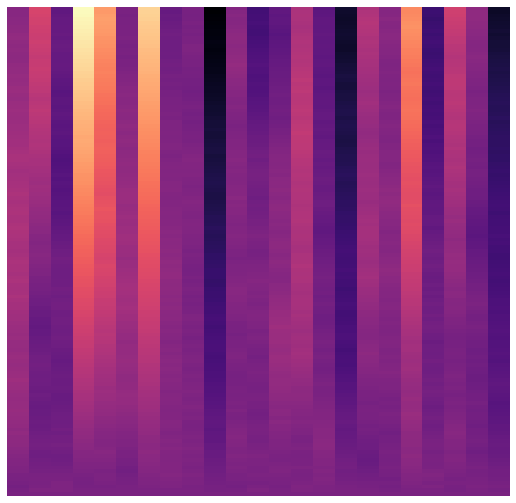

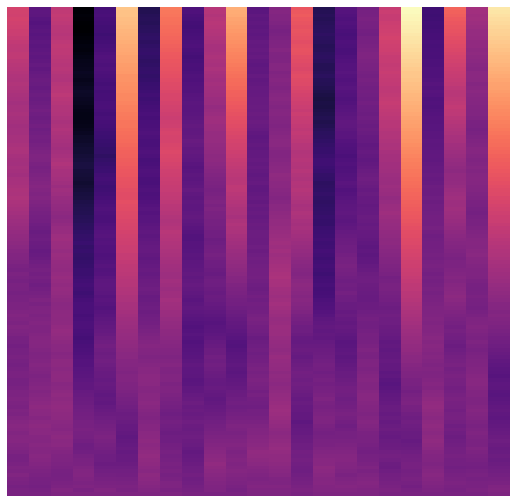

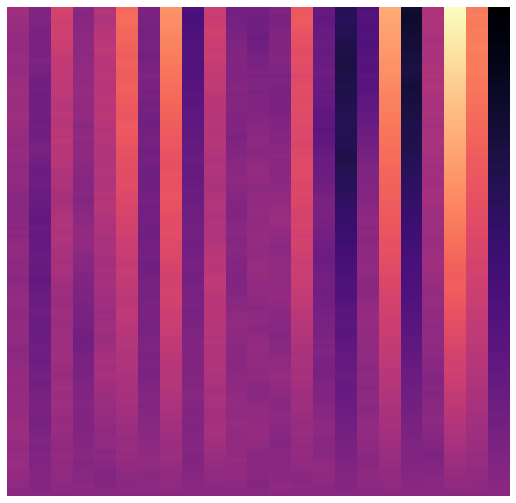

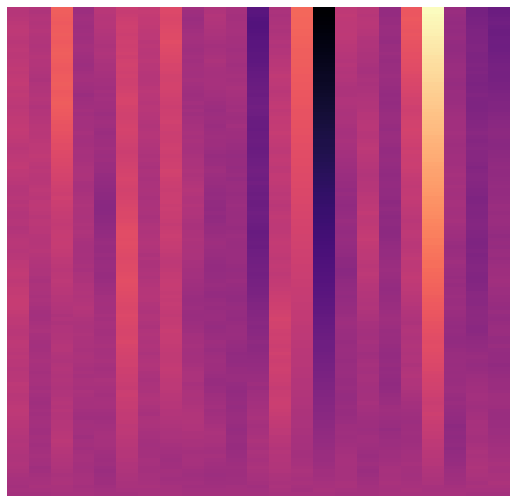

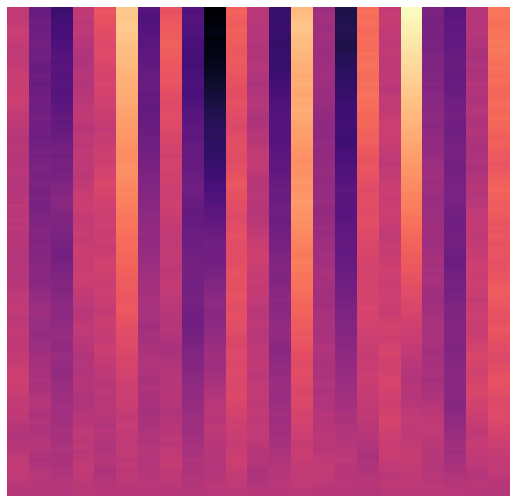

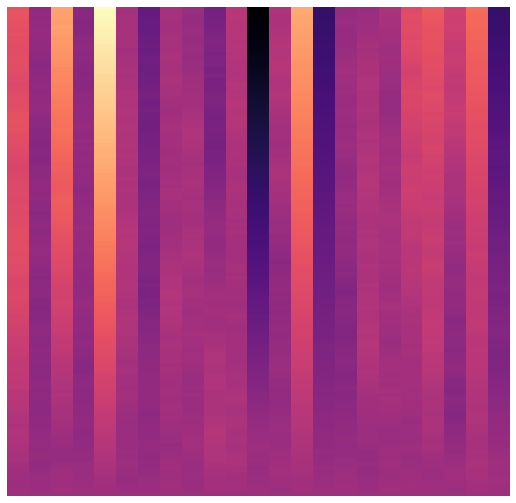

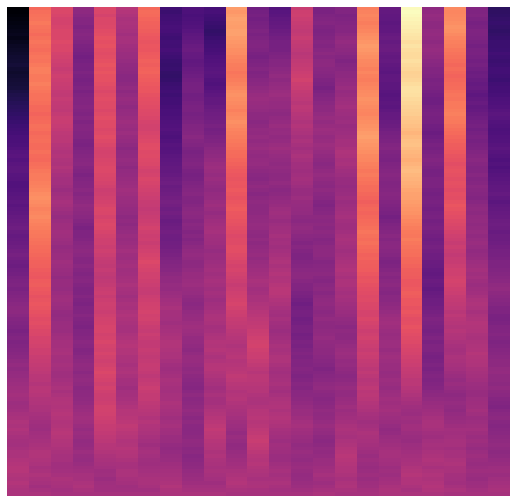

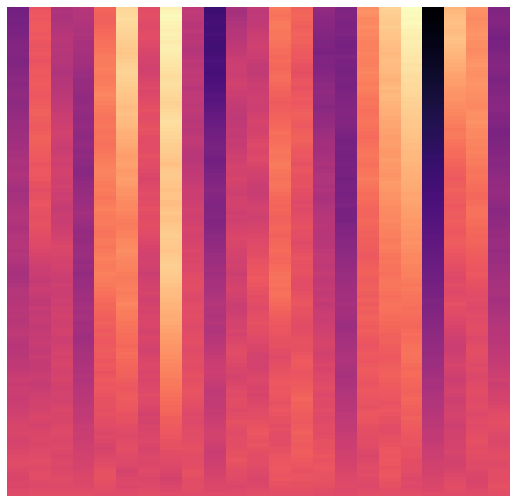

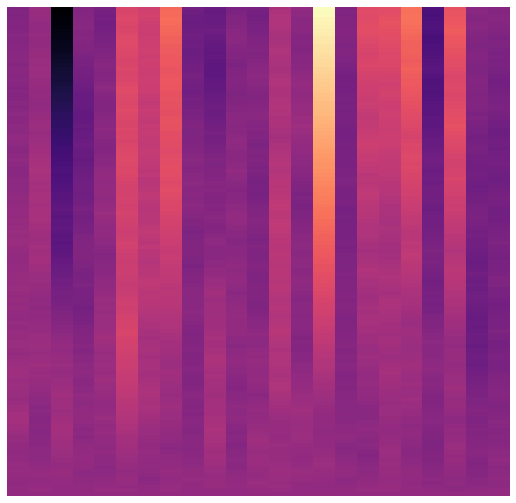

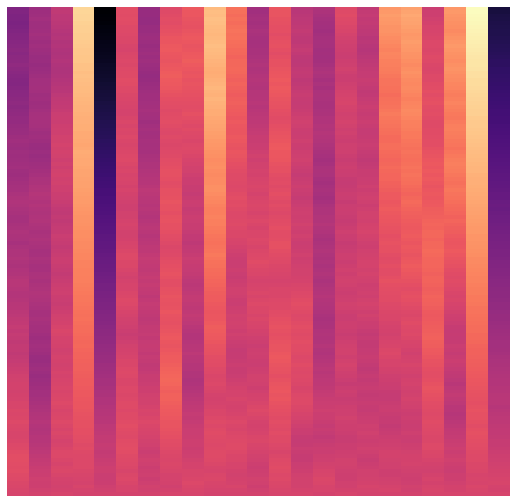

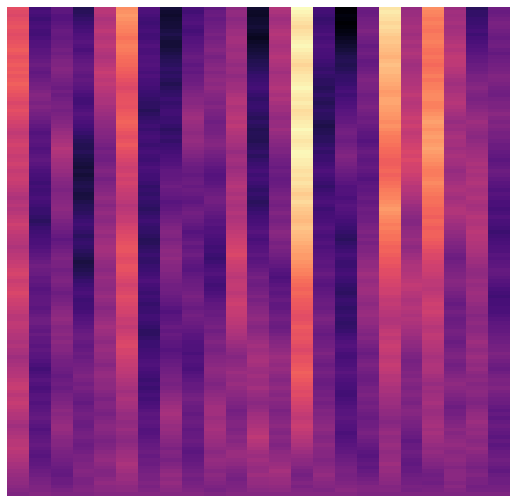

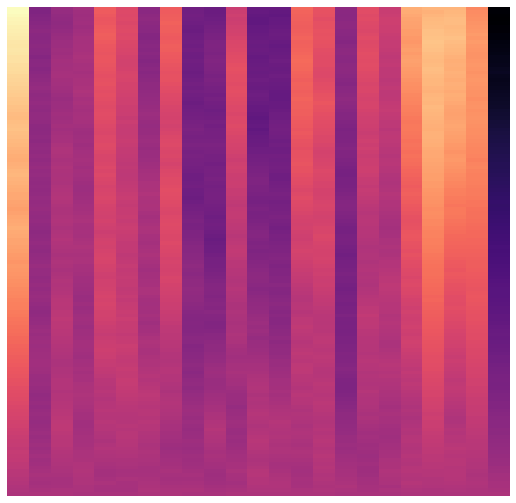

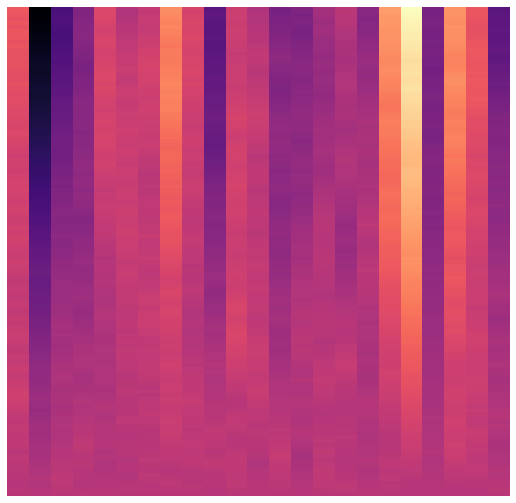

In [37]:
# limiting to 37 to match class weights
counter = 0
for i in train_negatives.index:
    if counter < 37:
        signal = np.array(train_negatives.iloc[i])
        fig, ax = plt.subplots(figsize=(9,9),frameon=False)
        fig, freqs, t, m = plt.specgram(signal, Fs=2, NFFT=256, mode='phase',cmap='magma')
        plt.axis(False)
        plt.savefig(path.join(train_negatives_outpath,'spec_{0}'.format(i)),bbox_inches='tight')
        counter+=1

## Preparing Images using Flow

In [ ]:
# Uncomment below if you need to install
# !pip install pillow
# !pip install opencv-contrib-python

In [22]:
%cd ../

/gdrive/My Drive/Colab Notebooks/starskope


In [ ]:
# converting an image with the Keras API

from PIL import Image
from keras.preprocessing import image
from imageio import imread
from skimage.transform import resize
import cv2,glob
from tqdm import tqdm

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

In [23]:
base_folder = r'specs/'
os.listdir(base_folder)

['train', 'test']

In [ ]:
train_base_dir = base_folder+'train/'
test_base_dir = base_folder+'test/'

train_planets_dir = train_base_dir+'planets/'
train_negatives_dir = train_base_dir+'negatives/'

test_planets_dir = test_base_dir+'planets/'
test_negatives_dir = test_base_dir+'negatives/'

In [ ]:
planet_train_files = glob.glob(train_planets_dir+'*.png')
negative_train_files = glob.glob(train_negatives_dir+'*.png')
all_train_files = [*planet_train_files, *negative_train_files]

planet_test_files = glob.glob(test_planets_dir+'*.png')
negative_test_files = glob.glob(test_negatives_dir+'*.png')
all_test_files = [*planet_test_files, *negative_test_files]

all_filename_vars = [planet_train_files, negative_train_files,
                     planet_test_files, negative_test_files]

In [ ]:
def load_img_cv2(filename, RGB=True):
    import cv2
    IMG = cv2.imread(filename)
    
    if RGB: 
        cmap = cv2.COLOR_BGR2RGB
    
    else:
        cmap=cv2.COLOR_BGR2GRAY
        
    return cv2.cvtColor(IMG, cmap)


In [ ]:
from PIL import Image
from keras.preprocessing import image
from imageio import imread
from skimage.transform import resize
from tqdm import tqdm

# From James Irving : https://colab.research.google.com/drive/1fwXPY3IDHxNiv7YgOpt3p5BvUaO4VruB#scrollTo=L5CNHxnagDjo

# defining a function to read images and convert to array
def read_img(img_path, target_size=(64,64,3)):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    return img

# Read in training and test filenames to produce X and y data splits.

def load_train_test_val(planet_train_filenames, negative_train_filenames, 
                        planet_test_filenames, negative_test_filenames, 
                        val_size=0.1,img_size=(64,64,3)):
    # y labels are encoded as 0=negatives, 1=planets
    # returns X_train, X_test, y_train, y_test, y_val

    import numpy as np
    
    display('[i] LOADING IMAGES')
    train_img = []
    train_label = []
    
    for img_path in tqdm(planet_train_files):
        train_img.append(read_img(img_path, target_size=img_size))
        train_label.append(1)
        
    for img_path in tqdm(negative_train_files):
        train_img.append(read_img(img_path, target_size=img_size))
        train_label.append(0)
        
    test_img = []
    test_label = []
    
    for img_path in tqdm(planet_test_files):
        test_img.append(read_img(img_path, target_size=img_size))
        test_label.append(1)
        
    for img_path in tqdm(negative_test_files):
        test_img.append(read_img(img_path, target_size=img_size))
        test_label.append(0)
        
    from sklearn.model_selection import train_test_split
    X = np.array(train_img, np.float32)
    y = np.array(train_label)
    
    X_test = np.array(test_img, np.float32)
    y_test = np.array(test_label)
    
    X_train,X_val, y_train, y_val = train_test_split(X,y,test_size=0.1)
    
    print('\n[i] Length of Splits:')
    print(f"X_train={len(X_train)}, X_test={len(X_test)}, X_val={len(X_val)}")
    
    return X_train, X_test, X_val, y_train, y_test, y_val



In [28]:
X_train,X_test,X_val,y_train,y_test,y_val=load_train_test_val(planet_train_files, 
                                                              negative_train_files,
                                                              planet_test_files, 
                                                              negative_test_files, 
                                                              val_size=0.1, 
                                                              img_size=(64,64,3))

'[i] LOADING IMAGES'

100%|██████████| 5/5 [00:01<00:00,  4.75it/s]


[i] Length of Splits:
X_train=66, X_test=10, X_val=8


In [ ]:
# create function for ImageDataGenerators for train, test and val data.
# returns training_set, test_set, val_set
def train_test_val_datagens(X_train, X_test, X_val, y_train, y_test, y_val,
                            BATCH_SIZE = 32,  train_datagen_kws=dict(
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)):
    """Creates ImageDataGenerators for train,test,val data.
    Returns: training_set,test_set,val_set"""
    ## Create training and test data
    from keras.preprocessing.image import ImageDataGenerator
    
    train_datagen = ImageDataGenerator(rescale = 1./255, **train_datagen_kws)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    val_datagen = ImageDataGenerator(rescale = 1./255)
    
    training_set = train_datagen.flow(X_train, y=y_train, batch_size=BATCH_SIZE)
    test_set = test_datagen.flow(X_test, y=y_test, batch_size=BATCH_SIZE)
    val_set = val_datagen.flow(X_val, y=y_val, batch_size=BATCH_SIZE)
    
    return training_set, test_set, val_set

In [ ]:
train_test_val_vars = [X_train, X_test, X_val, y_train, y_test, y_val]

In [ ]:
training_set,test_set,val_set=train_test_val_datagens(*train_test_val_vars)

In [ ]:
def get_shapes_dict(training_set, verbose=True):
    shapes = ["Batchsize", "img_width", "img_height", "img_dim"]
    SHAPES = dict(zip(shapes, training_set[0][0].shape))
    
    if verbose:
        print('SHAPES DICT:')
        print(SHAPES)
        print(training_set[0][0].shape)
        print('\n[i] Labels for batch (1=negative, 2=planet')
        print(training_set[0][1])
        
    return SHAPES 

In [33]:
SHAPES = get_shapes_dict(training_set)

SHAPES DICT:
{'Batchsize': 32, 'img_width': 64, 'img_height': 64, 'img_dim': 3}
(32, 64, 64, 3)

[i] Labels for batch (1=negative, 2=planet
[1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0]


In [ ]:
def complete_image_processing(*train_test_filenames,img_size=(64,64,3),val_size=0.1,
                              BATCH_SIZE = 32, train_datagen_kws= dict(
                                shear_range = 0.2, 
                                zoom_range = 0.2,
                                horizontal_flip = True),verbose=True):
    """Calls all 3 image prep functions and returns training,test,val datagens,
    plus SHAPES dict."""    
    # img_params = list(locals())
    # print(img_params[1:])
    # if verbose:
        # print('\n[i] Creating training ImageDataGenerator using:')
        # [print(f"{img_params[i]}") for i in range(len(img_params))];


    # print(len(train_test_filenames))
    if len(train_test_filenames) != 4:
        raise Exception('Must provide 4 filenames')
    train_test_val_vars = load_train_test_val(
        *train_test_filenames, val_size=0.1,img_size=img_size)

    training_set,test_set,val_set = train_test_val_datagens(*train_test_val_vars,
                                                            BATCH_SIZE=BATCH_SIZE)

    SHAPES = get_shapes_dict(training_set)

    return training_set,test_set,val_set,SHAPES

In [35]:
training_set,test_set,val_set,SHAPES = \
complete_image_processing(*all_filename_vars, img_size=(64,64,3),BATCH_SIZE=64)

'[i] LOADING IMAGES'

100%|██████████| 5/5 [00:00<00:00, 163.76it/s]



[i] Length of Splits:
X_train=66, X_test=10, X_val=8
SHAPES DICT:
{'Batchsize': 64, 'img_width': 64, 'img_height': 64, 'img_dim': 3}
(64, 64, 64, 3)

[i] Labels for batch (1=negative, 2=planet
[1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1
 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0]


# Model

In [ ]:
class Timer():
    def __init__(self, start=True,time_fmt='%m/%d/%y - %T'):
        import tzlocal
        import datetime as dt
        
        self.tz = tzlocal.get_localzone()
        self.fmt= time_fmt
        self._created = dt.datetime.now(tz=self.tz)
        
        if start:
            self.start()
            
    def get_time(self):
        import datetime as dt
        return dt.datetime.now(tz=self.tz)


        
    def start(self,verbose=True):
        self._laps_completed = 0
        self.start = self.get_time()
        if verbose: 
            print(f'[i] Timer started at {self.start.strftime(self.fmt)}')
    
    def stop(self, verbose=True):
        self._laps_completed += 1
        self.end = self.get_time()
        self.elapsed = self.end -  self.start
        if verbose: 
            print(f'[i] Timer stopped at {self.end.strftime(self.fmt)}')
            print(f'  - Total Time: {self.elapsed}')
    
    

In [37]:
#https://colab.research.google.com/notebooks/pro.ipynb
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May  3 08:47:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [38]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


## CNN

For the first iteration, we'll construct a CNN model, after which we will build an RBM.

In [4]:
#!pip install fsds_100719
from fsds_100719.imports import *


fsds_1007219  v0.7.21 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [ ]:
clock = fs.jmi.Clock()

In [40]:
# # Part 1 - Building the CNN

clock.tic('')
# # Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

# # Initialising the CNN
classifier = Sequential()

# # Step 1 - Convolution
classifier.add(Conv2D(SHAPES['Batchsize'], (3, 3),
                             input_shape = (SHAPES['img_width'],
                                            SHAPES['img_height'],
                                            SHAPES['img_dim']),
                             activation = 'relu'))

classifier.add(Conv2D(SHAPES['Batchsize'], (3, 3),
                      input_shape = (SHAPES['img_width'], 
                                     SHAPES['img_height'],
                                     SHAPES['img_dim']),
                       activation = 'relu'))
# # Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# # Adding a second convolutional layer
classifier.add(Conv2D(SHAPES['Batchsize'], (3, 3),
                      activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# # Step 3 - Flattening
classifier.add(Flatten())

# # Step 4 - Full connection
classifier.add(Dense(units = SHAPES['Batchsize'], activation = 'relu'))

classifier.add(Dense(units = 1, activation = 'sigmoid'))

# # Compiling the CNN
classifier.compile(optimizer = 'adam', 
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])
# print()
display(classifier.summary())


# # Part 2 - Fitting the CNN to the images

history =classifier.fit_generator(training_set,
                         steps_per_epoch = 500,
                         epochs = 3,
                         validation_data = val_set,#test_set,
                         validation_steps =100,workers=-1)

clock.toc('')

--- CLOCK STARTED @:    05/03/20 - 08:48:04 AM           Label:            --- 
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
________________________________________

None

Epoch 1/3
500/500 [==============================] - 31s 61ms/step - loss: 0.5879 - accuracy: 0.6630 - val_loss: 0.3231 - val_accuracy: 0.7500
Epoch 2/3
500/500 [==============================] - 24s 48ms/step - loss: 0.2982 - accuracy: 0.8691 - val_loss: 0.9494 - val_accuracy: 0.6250
Epoch 3/3
500/500 [==============================] - 24s 49ms/step - loss: 0.1016 - accuracy: 0.9618 - val_loss: 1.4923 - val_accuracy: 0.7500
--- TOTAL DURATION   =  1 min, 27.978 sec --- 


Lap #,Start Time,Duration,Label
TOTAL,05/03/20 - 08:48:04 AM,"1 min, 27.978 sec",


In [ ]:

# ********* STARSKØPE.SPACEKIT.COMPUTER ********* #
""" 
helper functions for computing predictions and scores 
for evaluating a machine learning model.
TODO       
- save metrics to textfile/pickle objs and/or dictionaries
"""
# -----------------
# STATIC CLASS METHODS 
# -----------------
# * predictions 
#   get_preds()
#   fnfp()
#
# * Plots
#   keras_history()
#   fusion_matrix()
#   roc_plots()
# 
# * One-shot All the above
#   compute()
#
# ********* /\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/ ********* #

import pandas as pd
import numpy as np
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, roc_curve, roc_auc_score, jaccard_score
from sklearn.metrics import confusion_matrix 



def get_preds(X,y,model=None,verbose=False):
    if model is None:
        model=model
    # class predictions 
    y_true = y.flatten()
    
    y_pred = model.predict_classes(X).flatten() 
    preds = pd.Series(y_pred).value_counts(normalize=False)
    
    if verbose:
        print(f"y_pred:\n {preds}")
        print("\n")

    return y_true, y_pred


def fnfp(X,y,model, training=False):

    import numpy as np

    y_pred = np.round( model.predict(X) )

    pos_idx = y==1
    neg_idx = y==0

    #tp = np.sum(y_pred[pos_idx]==1)/y_pred.shape[0]
    fn = np.sum(y_pred[pos_idx]==0)/y_pred.shape[0]

    #tn = np.sum(y_pred[neg_idx]==0)/y_pred.shape[0]
    fp = np.sum(y_pred[neg_idx]==1)/y_pred.shape[0]

    if training:
        print(f"FN Rate (Training): {round(fn*100,4)}%")
        print(f"FP Rate (Training): {round(fp*100,4)}%")
    else:
        print(f"FN Rate (Test): {round(fn*100,4)}%")
        print(f"FP Rate (Test): {round(fp*100,4)}%")


def keras_history(history, figsize=(10,4)):
    """
    side by side sublots of training val accuracy and loss (left and right respectively)
    """
    
    import matplotlib.pyplot as plt
    
    fig,axes=plt.subplots(ncols=2,figsize=(15,6))
    axes = axes.flatten()

    ax = axes[0]
    ax.plot(history.history['accuracy'])
    ax.plot(history.history['val_accuracy'])
    ax.set_title('Model Accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Test'], loc='upper left')

    ax = axes[1]
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Test'], loc='upper left')
    plt.show()


 # FUSION_MATRIX()
    
def fusion_matrix(matrix, classes=None, normalize=False, title='Fusion Matrix', cmap='Blues',
    print_raw=False): 
    """
    FUSION MATRIX!
    -------------
    It's like a confusion matrix...without the confusion.
    
    matrix: can pass in matrix or a tuple (ytrue,ypred) to create on the fly 
    classes: class names for target variables
    """
    from sklearn import metrics                       
    from sklearn.metrics import confusion_matrix #ugh
    import itertools
    import numpy as np
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    
    # make matrix if tuple passed to matrix:
    if isinstance(matrix, tuple):
        y_true = matrix[0].copy()
        y_pred = matrix[1].copy()
        
        if y_true.ndim>1:
            y_true = y_true.argmax(axis=1)
        if y_pred.ndim>1:
            y_pred = y_pred.argmax(axis=1)
        fusion = metrics.confusion_matrix(y_true, y_pred)
    else:
        fusion = matrix
    
    # INTEGER LABELS
    if classes is None:
        classes=list(range(len(matrix)))

    #NORMALIZING
    # Check if normalize is set to True
    # If so, normalize the raw fusion matrix before visualizing
    if normalize:
        fusion = fusion.astype('float') / fusion.sum(axis=1)[:, np.newaxis]
        fmt='.2f'
    else:
        fmt='d'
    
    # PLOT
    fig, ax = plt.subplots(figsize=(10,10))
    plt.imshow(fusion, cmap=cmap, aspect='equal')
    
    # Add title and axis labels 
    plt.title(title) 
    plt.ylabel('TRUE') 
    plt.xlabel('PRED')
    
    # Add appropriate axis scales
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    #ax.set_ylim(len(fusion), -.5,.5) ## <-- This was messing up the plots!
    
    # Text formatting
    fmt = '.2f' if normalize else 'd'
    # Add labels to each cell
    thresh = fusion.max() / 2.
    # iterate thru matrix and append labels  
    for i, j in itertools.product(range(fusion.shape[0]), range(fusion.shape[1])):
        plt.text(j, i, format(fusion[i, j], fmt),
                horizontalalignment='center',
                color='white' if fusion[i, j] > thresh else 'black',
                size=14, weight='bold')
    
    # Add a legend
    plt.colorbar()
    plt.show() 
    return fusion, fig



def roc_plots(X,y,model):
    from sklearn import metrics
    from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

    y_true = y.flatten()
    y_hat = model.predict(X)

    fpr, tpr, thresholds = roc_curve(y_true, y_hat) 

    # Threshold Cutoff for predictions
    crossover_index = np.min(np.where(1.-fpr <= tpr))
    crossover_cutoff = thresholds[crossover_index]
    crossover_specificity = 1.-fpr[crossover_index]

    fig,axes=plt.subplots(ncols=2, figsize=(15,6))
    axes = axes.flatten()

    ax=axes[0]
    ax.plot(thresholds, 1.-fpr)
    ax.plot(thresholds, tpr)
    ax.set_title("Crossover at {0:.2f}, Specificity {1:.2f}".format(crossover_cutoff, crossover_specificity))

    ax=axes[1]
    ax.plot(fpr, tpr)
    ax.set_title("ROC area under curve: {0:.2f}".format(roc_auc_score(y_true, y_hat)))
    plt.show()
    
    roc = roc_auc_score(y_true,y_hat)

    return roc


    ### COMPUTE SCORES ###

def compute(X, y, model, hist=None, preds=True, summary=True, fusion=True, 
            classes=None, report=True, roc=True):
    """
    evaluates model predictions and stores the output in a dict
    returns `results`
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn import metrics
    from sklearn.metrics import jaccard_score,accuracy_score, recall_score, fowlkes_mallows_score

    # initialize a spare improbability drive
    res = {}
    res['model'] = model.name
    
    # class predictions 
    if preds:
        y_true = y.flatten()
        y_pred = model.predict_classes(X).flatten()
        res['preds'] = [y_pred]

    if summary:
        summary = model.summary()
        res['summary'] = model.summary


    # FUSION MATRIX
    if fusion:
        if classes is None:
            classes=['0','1']
        else:
            classes=classes
        # Plot fusion matrix
        FM = fusion_matrix(matrix=(y_true,y_pred), 
                                    classes=classes)
        res['FM'] = FM

    # ROC Area Under Curve
    if roc:
        ROC = roc_plots(X, y, model)
        res['ROC'] = ROC

    # CLASSIFICATION REPORT
    if report:
        num_dashes=20
        print('\n')
        print('---'*num_dashes)
        print('\tCLASSIFICATION REPORT:')
        print('---'*num_dashes)
        # generate report
        report = metrics.classification_report(y_true,y_pred)
        res['report'] = report
        print(report)


    # save to dict:
    res['jaccard'] = jaccard_score(y_true, y_pred)
    res['fowlkes'] = fowlkes_mallows_score(y_true,y_pred)
    res['accuracy'] = accuracy_score(y_true, y_pred)
    res['recall'] = recall_score(y_true, y_pred)
    
    #Plot Model Training Results (PLOT KERAS HISTORY)
    if hist is not None:
        HIST = keras_history(hist)
        res['HIST'] = HIST

    return res


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

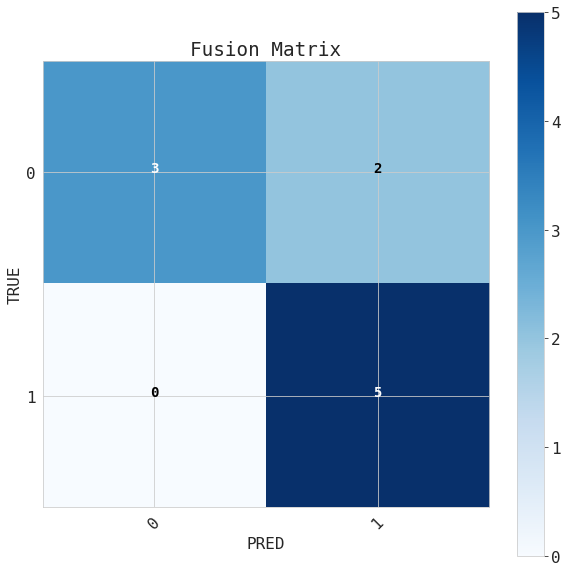

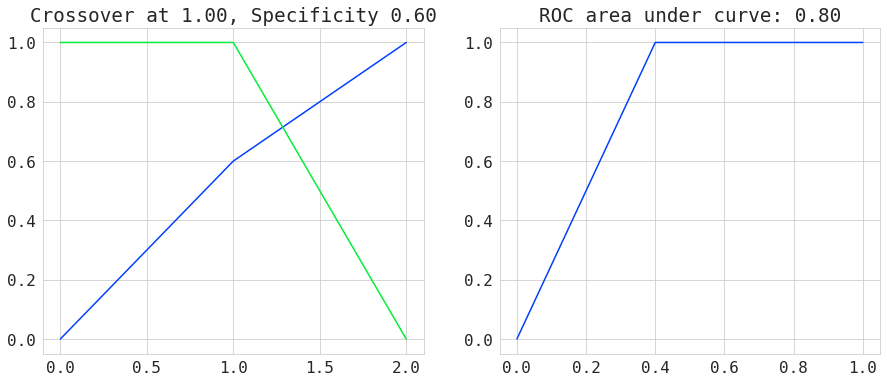



------------------------------------------------------------
	CLASSIFICATION REPORT:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.71      1.00      0.83         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10



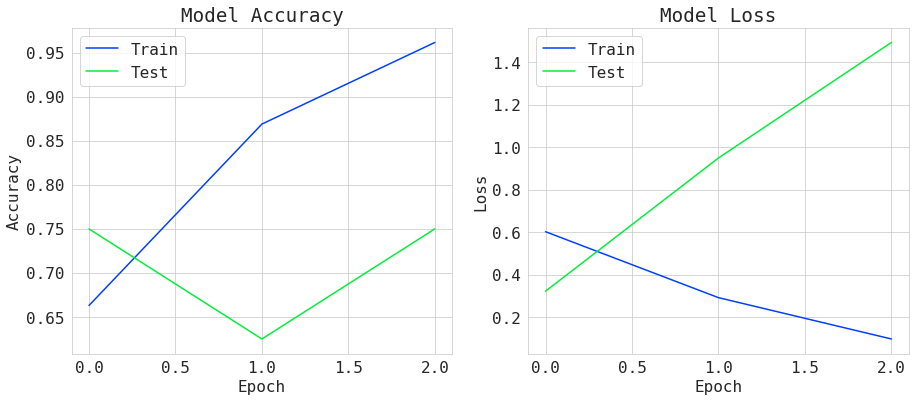

In [46]:
res1 = compute(X_test,y_test, model=classifier, hist=history)

In [ ]:
def cd_gdrive_mkdirs(model_subfolder='data/models/planet_vs_neg/'):
    
    """cd to /gdrive/My Drive/ to allow for saving files to google drive
    Also makes all subfolders in 'model_subfolder'"""
    
    import os
    ## To save to Gdrive, must first chdir to My Drive (so there's no spaces in fpath)
    curdir = os.path.abspath(os.curdir)
    data_folder =r'/gdrive/My Drive/Colab Notebooks/starskope/data'

    try:
        os.chdir(data_folder)
    except Exception as e:
        print(f'ERROR: {e}')

    try:
        os.makedirs(model_subfolder,exist_ok=True)
        print('Directories created.')
    except:
        print('Error making directories')

    return print(os.path.abspath(os.curdir))


In [48]:
model_subfolder='data/models/planet_vs_neg/'
cd_gdrive_mkdirs(model_subfolder=model_subfolder)

print('\n',model_subfolder)
os.listdir(model_subfolder)

Directories created.
/gdrive/My Drive/Colab Notebooks/starskope/data

 data/models/planet_vs_neg/


[]

In [ ]:
# checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

def create_csvlogger(filename):
    return CSVLogger(filename, separator=',', append=False)

def create_checkpoint(monitor='val_accuracy',
                      model_subfolder='data/models/planet_vs_neg/'):
    filepath=model_subfolder+"weights-improvement-{epoch:02d}-{"+monitor+":.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=1, 
                                 save_best_only=True, mode='max')
    return checkpoint

def create_early_stopping(monitor = 'val_accuracy',min_delta = 0, patience = 1,
                          verbose = 1, restore_best_weights = True):

    args = locals()
    earlystop = EarlyStopping(**args)
    return earlystop

In [55]:
# def get_callbacks():
model_subfolder='data/models/planet_vs_neg/'
cd_gdrive_mkdirs(model_subfolder=model_subfolder)
callbacks_list = [create_checkpoint('val_accuracy'),
                  create_early_stopping(),
                  create_csvlogger(model_subfolder+'callback_log.csv')]
callbacks_list

Directories created.
/gdrive/My Drive/Colab Notebooks/starskope/data


In [ ]:
# filepath=model_subfolder+
monitor = 'val_accuracy'
filepath=model_subfolder+"weights-improvement-{epoch:02d}-{"+monitor+":.2f}.hdf5"
#filepath
# model_subfolder

In [57]:
model_subfolder='data/models/planet_vs_neg/'
cd_gdrive_mkdirs(model_subfolder=model_subfolder)
callbacks_list = [create_checkpoint('val_accuracy'),
                  create_early_stopping(),
                  create_csvlogger(model_subfolder+'callback_log.csv')]
callbacks_list

Directories created.
/gdrive/My Drive/Colab Notebooks/starskope/data


In [58]:
# Part 1 - Building the CNN
clock = fs.jmi.Clock()
clock.tic('')
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

# Initialising the CNN
classifier2 = Sequential()

# Step 1 - Convolution
classifier2.add(Conv2D(SHAPES['Batchsize'], (5, 5),
                             input_shape = (SHAPES['img_width'],
                                            SHAPES['img_height'],
                                            SHAPES['img_dim']),
                             activation = 'relu'))

classifier2.add(Conv2D(SHAPES['Batchsize'], (3, 3),
                      input_shape = (SHAPES['img_width'], 
                                     SHAPES['img_height'],
                                     SHAPES['img_dim']),
                       activation = 'relu'))
# Step 2 - Pooling
classifier2.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier2.add(Conv2D(SHAPES['Batchsize'], (3, 3),
                      activation = 'relu'))
classifier2.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier2.add(Flatten())

# Step 4 - Full connection
classifier2.add(Dense(units = SHAPES['Batchsize'], activation = 'relu'))

classifier2.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier2.compile(optimizer = 'adam', 
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])
print()
display(classifier2.summary())
# Part 2 - Fitting the CNN to the images

history2 =classifier2.fit_generator(training_set,
                         steps_per_epoch = 1000,
                         epochs = 3,
                         validation_data = val_set,#test_set,
                         validation_steps = 500,workers=-1,
                         callbacks=callbacks_list)

clock.toc('')



--- CLOCK STARTED @:    05/03/20 - 09:15:43 AM           Label:            --- 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 60, 60, 64)        4864      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 27, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10816)             0         
_______________________________________

None

Epoch 1/3
1000/1000 [==============================] - 50s 50ms/step - loss: 0.4111 - accuracy: 0.7974 - val_loss: 0.7305 - val_accuracy: 0.7500

Epoch 00001: val_accuracy improved from -inf to 0.75000, saving model to data/models/planet_vs_neg/weights-improvement-01-0.75.hdf5
Epoch 2/3
1000/1000 [==============================] - 50s 50ms/step - loss: 0.1581 - accuracy: 0.9497 - val_loss: 2.2786 - val_accuracy: 0.6250

Epoch 00002: val_accuracy did not improve from 0.75000
Restoring model weights from the end of the best epoch
Epoch 00002: early stopping
--- TOTAL DURATION   =  1 min, 40.158 sec --- 


Lap #,Start Time,Duration,Label
TOTAL,05/03/20 - 09:15:43 AM,"1 min, 40.158 sec",


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 60, 60, 64)        4864      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 27, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

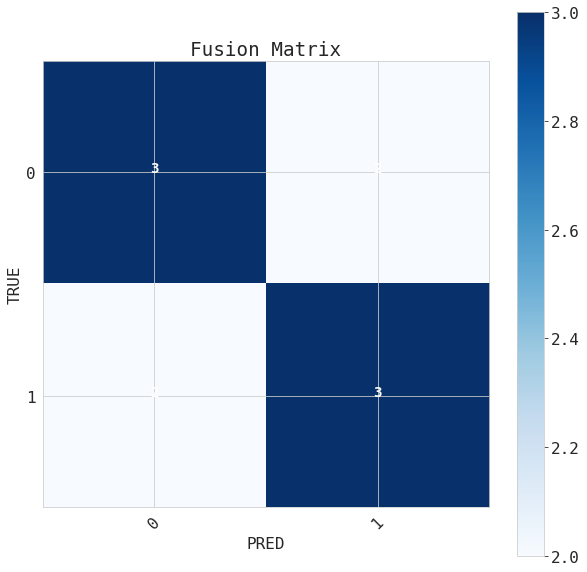

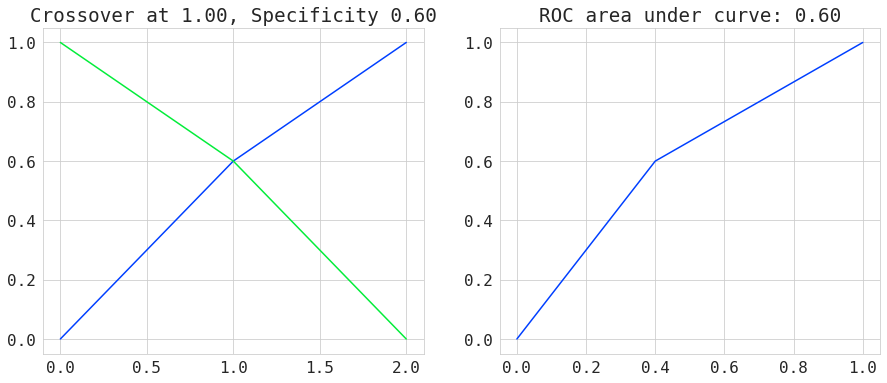



------------------------------------------------------------
	CLASSIFICATION REPORT:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.60      0.60      0.60         5

    accuracy                           0.60        10
   macro avg       0.60      0.60      0.60        10
weighted avg       0.60      0.60      0.60        10



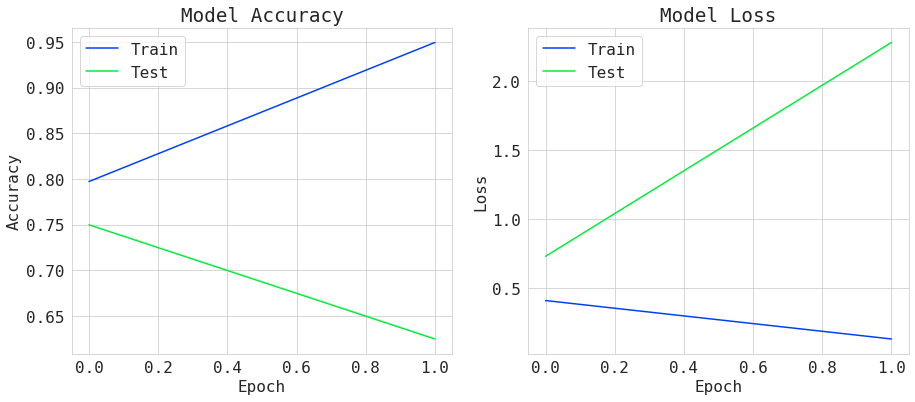

In [59]:
res2 = compute(X_test,y_test, model=classifier2, hist=history2)

In [ ]:
# from keras.utils import 
model_loaded = classifier2
model_loaded.load_weights('data/models/planet_vs_neg/weights-improvement-01-0.75.hdf5')
#model_loaded.weights

In [63]:
%cd ../

/gdrive/My Drive/Colab Notebooks/starskope


In [ ]:
def save_model(model,model_subfolder = 'data/models/planet_vs_neg/',
               base_modelname = 'CNN_planet_neg_05022020', as_json=True,
               return_fpaths=True,verbose=True):
    import os
    ## To save to Gdrive, must first chdir to My Drive (so there's no spaces in fpath)
    curdir = os.path.abspath(os.curdir)

    main_folder =r'/gdrive/My Drive/Colab Notebooks/starskope'
    model_subfolder = 'data/models/planet_vs_neg/'

    try:
        os.chdir(main_folder)
        os.makedirs(model_subfolder,exist_ok=True)
    except Exception as e:
        print(f'ERROR: {e}')

    # os.listdir(model_subfolder)
    # https://jovianlin.io/saving-loading-keras-models/
    try:
        weight_fpath = model_subfolder+base_modelname+'_weights.h5'
        model.save_weights(weight_fpath, overwrite=True)

        if as_json:
            model_fpath = model_subfolder+base_modelname+'_model.json'
            # Save the model architecture
            with open(model_fpath, 'w') as f:
                f.write(model.to_json())
        else:
            model_fpath = model_subfolder+base_modelname+'_model.h5'
            model.save(model_fpath)
        if verbose: 
            print(f"[io] Model architecture saved as {model_fpath}")
            print(f"[io] Model weights saved as {weight_fpath}")
        else:
            print(f"[io] Successfully saved model.")

    except Exception as e:
        import warnings
        warnings.warn(f"ERROR SAVING: {e}")
    if return_fpaths:
        return model_fpath, weight_fpath



def load_model(model_fpath,weight_fpath=None,as_json=True):
    from keras.models import model_from_json
    if (as_json == True) & (weight_fpath is None):
        raise Exception('If using as_json=True, must provide ')

    # Model reconstruction from JSON file
    with open(model_fpath, 'r',encoding="utf8") as f:
        model2 = model_from_json(f.read())

    # Load weights into the new model
    model2.load_weights(weight_fpath)
    display(model2.summary())
    return model2



In [65]:
model_fpath,weight_fpath = save_model(classifier2)
model_loaded = load_model(model_fpath,weight_fpath)

[io] Model architecture saved as data/models/planet_vs_neg/CNN_planet_neg_05022020_model.json
[io] Model weights saved as data/models/planet_vs_neg/CNN_planet_neg_05022020_weights.h5
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 60, 60, 64)        4864      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 27, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
fla

None

## Tuning with Gridsearch

In [ ]:
def build_model(SHAPES,filter_size=(3,3), pool_size=(2,2),dropout=True): 
    vars_ = locals()
    print(f'[i] MODEL BUILT USING:\n\t{vars_}')
    # Part 1 - Building the CNN

    # Importing the Keras libraries and packages
    from keras.models import Sequential
    from keras.layers import Conv2D
    from keras.layers import MaxPooling2D
    from keras.layers import Flatten
    from keras.layers import Dense, Dropout

    # Initialising the CNN
    classifier = Sequential()

    # Step 1 - Convolution
    classifier.add(Conv2D(SHAPES['Batchsize'], filter_size,
                                input_shape = (SHAPES['img_width'], SHAPES['img_height'], SHAPES['img_dim']),
                                activation = 'relu'))

    classifier.add(Conv2D(SHAPES['Batchsize'], filter_size,
                        input_shape = (SHAPES['img_width'], SHAPES['img_height'], SHAPES['img_dim']), activation = 'relu'))

    # Step 2 - Pooling
    classifier.add(MaxPooling2D(pool_size = pool_size))
    if dropout:
        classifier.add(Dropout(0.2))

    # Adding a second convolutional layer
    classifier.add(Conv2D(SHAPES['Batchsize'], filter_size, activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = pool_size))

    # Step 3 - Flattening
    classifier.add(Flatten())

    # Step 4 - Full connection
    classifier.add(Dense(units = SHAPES['Batchsize'], activation = 'relu'))
    classifier.add(Dense(units = 1, activation = 'sigmoid'))

    # Compiling the CNN
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                       metrics = ['accuracy'])
    display(classifier.summary())
    return classifier
    # Part 2 - Fitting the CNN to the images



def train_model(classifier,training_set, test_set, 
                params=dict(steps_per_epoch = 2000,
                            epochs = 3, validation_steps = 500,
                            workers=-1)):
    vars = locals()
    print(f'[i] Training model using\n\t{vars}\n')
    clock = Timer()
    
    history_ = classifier.fit_generator(training_set,
                                        validation_data = test_set,
                                        **params)

    clock.stop()
    return history_


[i] MODEL BUILT USING:
	{'dropout': True, 'pool_size': (2, 2), 'filter_size': (3, 3), 'SHAPES': {'Batchsize': 64, 'img_width': 64, 'img_height': 64, 'img_dim': 3}}
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxP

None

[i] Training model using
	{'params': {'steps_per_epoch': 2000, 'epochs': 3, 'validation_steps': 500, 'workers': -1}, 'test_set': <keras.preprocessing.image.NumpyArrayIterator object at 0x7faefa99d9b0>, 'training_set': <keras.preprocessing.image.NumpyArrayIterator object at 0x7faefa99de48>, 'classifier': <keras.engine.sequential.Sequential object at 0x7fae18a56128>}

[i] Timer started at 05/03/20 - 09:34:42
Epoch 1/3
2000/2000 [==============================] - 100s 50ms/step - loss: 0.2498 - accuracy: 0.8732 - val_loss: 1.6502 - val_accuracy: 0.6000
Epoch 2/3
2000/2000 [==============================] - 100s 50ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 2.4729 - val_accuracy: 0.6000
Epoch 3/3
2000/2000 [==============================] - 100s 50ms/step - loss: 0.0440 - accuracy: 0.9850 - val_loss: 5.2819 - val_accuracy: 0.7000
[i] Timer stopped at 05/03/20 - 09:39:43
  - Total Time: 0:05:00.565197
Model: "sequential_8"
__________________________________________________________

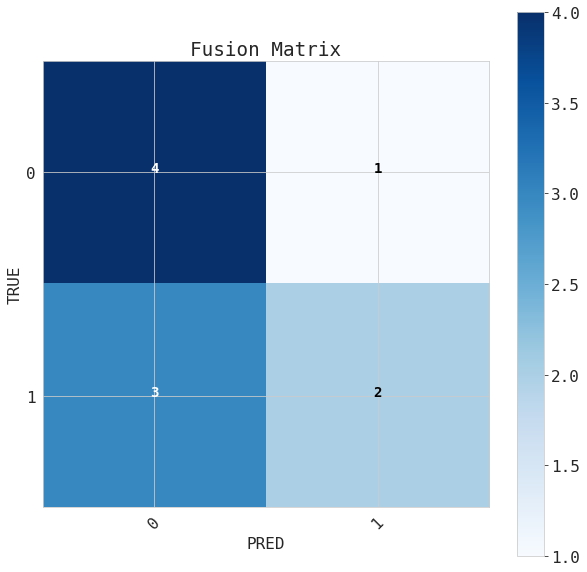

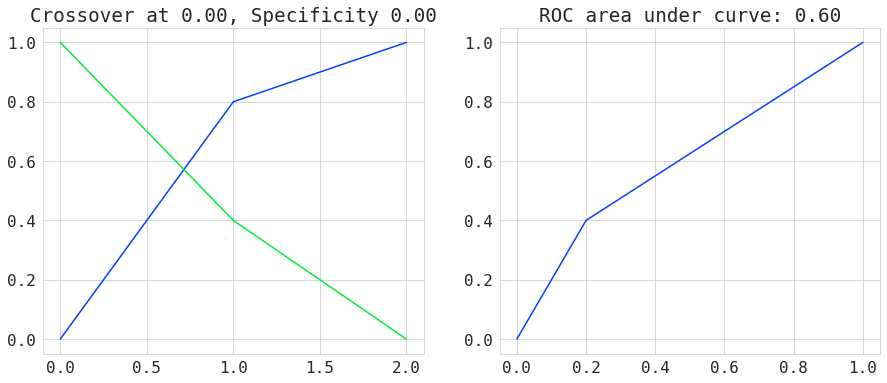



------------------------------------------------------------
	CLASSIFICATION REPORT:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.67      0.40      0.50         5

    accuracy                           0.60        10
   macro avg       0.62      0.60      0.58        10
weighted avg       0.62      0.60      0.58        10



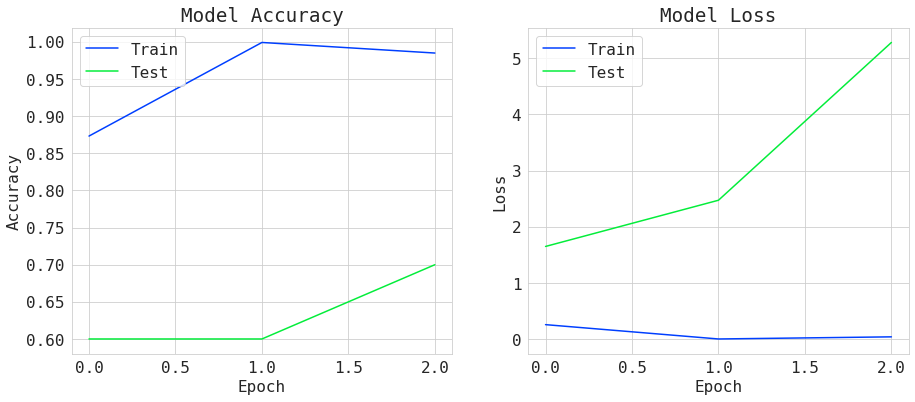

In [73]:

model_3 = build_model(SHAPES)
history_3 = train_model(model_3,training_set,test_set)
res3=compute(X_test,y_test,model=model_3,hist=history_3)

## Saving/Loading

In [74]:
## To save to Gdrive, must first chdir to My Drive (so there's no spaces in fpath)
curdir = os.path.abspath(os.curdir)

main_folder =r'/gdrive/My Drive/Colab Notebooks/starskope'
model_subfolder = 'data/models/planet_vs_neg/'

try:
    os.chdir(main_folder)
    os.makedirs(model_subfolder,exist_ok=True)
except Exception as e:
    print(f'ERROR: {e}')
os.listdir(model_subfolder)

['CNN_planet_neg_05022020_weights.h5', 'CNN_planet_neg_05022020_model.json']